In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk, math, time, re, os, pickle
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [11]:
def get_data():
    data = pd.read_pickle('16k_apparel_data_preprocessed.pkl')
    with open('word2vec_model', 'rb') as handle:
        model = pickle.load(handle)

    #load saved image features and corresponding ASINS info.
    bottleneck_features_train = np.load('16k_data_cnn_features.npy')
    asins = np.load('16k_data_cnn_feature_asins.npy')
    asins = list(asins)
    
    return data, model, bottleneck_features_train, asins

In [32]:
def clean_up_and_vectorize(data):
    # some of the brand values are empty. 
    # Need to replace Null with string "NULL"
    data['brand'].fillna(value="Not given", inplace=True )

    # replace spaces with hypen
    brands = [x.replace(" ", "-") for x in data['brand'].values]
    types = [x.replace(" ", "-") for x in data['product_type_name'].values]
    colors = [x.replace(" ", "-") for x in data['color'].values]
    
    idf_title_vectorizer = CountVectorizer()
    idf_title_features = idf_title_vectorizer.fit_transform(data['title'])
    
    #CountVectorizer is used to encode brands to one-hot encoding
    brand_vectorizer = CountVectorizer()
    brand_features = brand_vectorizer.fit_transform(brands)

    type_vectorizer = CountVectorizer()
    type_features = type_vectorizer.fit_transform(types)

    color_vectorizer = CountVectorizer()
    color_features = color_vectorizer.fit_transform(colors)
    
    return data, idf_title_vectorizer, idf_title_features, brand_vectorizer, brand_features, brands, type_vectorizer, type_features, types, color_vectorizer, color_features, colors

In [5]:
# this function will add the vectors of each word and return the avg vector of given sentence
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentence: title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information that takes two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    
    # intialize a vector of size 300 with all zeros
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    
    return featureVec

In [6]:
def calculate_idf_weighted_w2v(data):
    doc_id = 0
    w2v_title_weight = []
    # for every title we build a weighted vector representation
    for i in data['title']:
        w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
        doc_id += 1
    # w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
    w2v_title_weight = np.array(w2v_title_weight)
    return w2v_title_weight

In [54]:
def heat_map_w2v_brand(sentence1, sentence2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentence1 : title1, input apparel
    # sentence2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax1.set_title(sentence2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

In [38]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)


In [85]:
def idf_w2v_brand(doc_id, idf_wt, ex_feat_wt, image_feat_wt, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the cosine distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    
    
#     doc_id = asins.index(df_asins[doc_id])
    img_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
#     print('Idf wv2 shape is {}\n Ex features shape is {}\n Image features shape is {} \n'.format(idf_w2v_dist.shape, ex_feat_dist.shape, img_feat_dist.shape))
    #this is one way to incorporate weights
    pairwise_dist   = ( (idf_wt * idf_w2v_dist) +  (ex_feat_wt * ex_feat_dist) + (image_feat_wt * img_feat_dist)) / float(idf_wt + ex_feat_wt + image_feat_wt)
#     pairwise_dist   = (idf_wt * idf_w2v_dist +  ex_feat_wt * ex_feat_dist)/float(idf_wt + ex_feat_wt)
    
    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(sentence1 = data['title'].loc[df_indices[0]], sentence2 = data['title'].loc[df_indices[i]], 
                           url= data['medium_image_url'].loc[df_indices[i]], 
                           doc_id1 = indices[0], doc_id2 = indices[i],
                           df_id1 = df_indices[0], df_id2 = df_indices[i], 
                           model = 'weighted')
        print('ASIN_Q :',data['asin'].loc[df_indices[0]])
        print('Brand_Q :',data['brand'].loc[df_indices[0]])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

In [34]:
data, model, bottleneck_features_train, asins = get_data()
df_asins = list(data['asin'])
vocab = model.keys()
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [35]:
data, idf_title_vectorizer, idf_title_features, brand_vectorizer, brand_features, brands, \
        type_vectorizer, type_features, types, color_vectorizer, color_features, colors = clean_up_and_vectorize(data)
extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [36]:
w2v_title_weight =  calculate_idf_weighted_w2v(data)

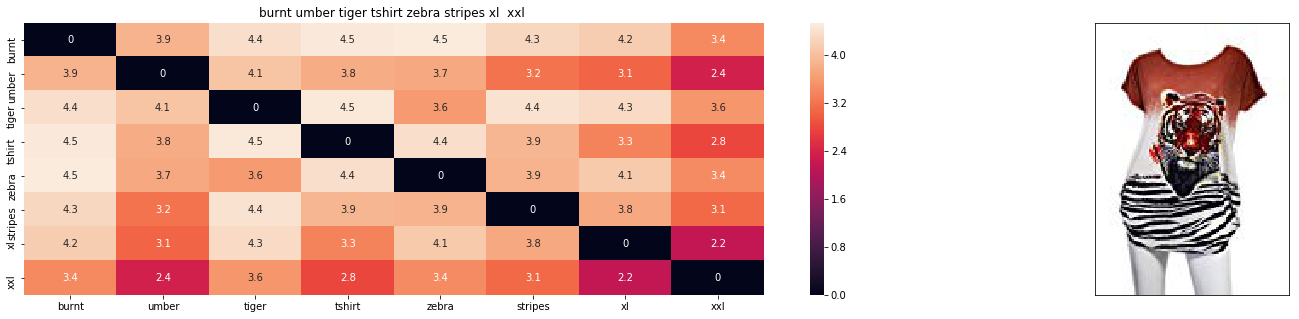

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


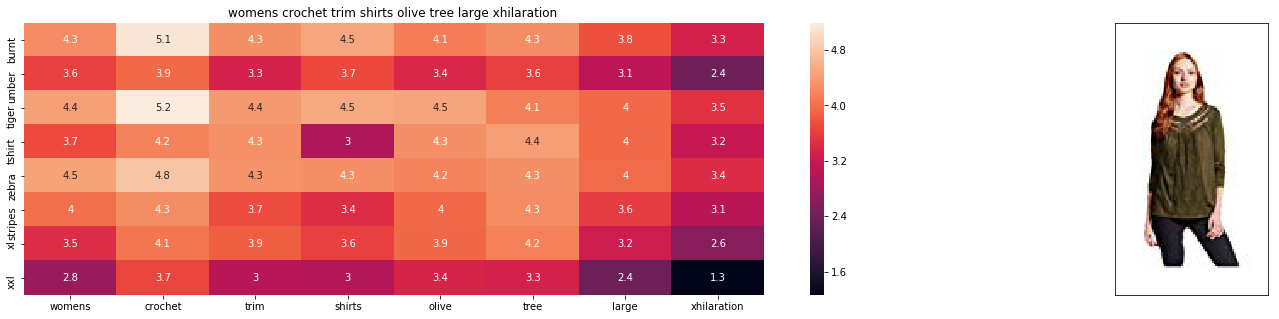

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XBHNM7J
Brand : Xhilaration
euclidean distance from input : 13.809066581966992


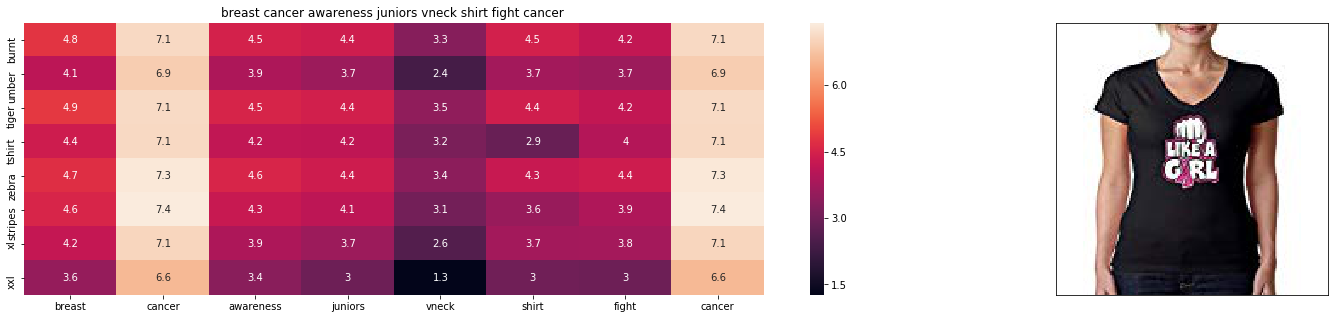

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B016CU40IY
Brand : Juiceclouds
euclidean distance from input : 14.448230402231491


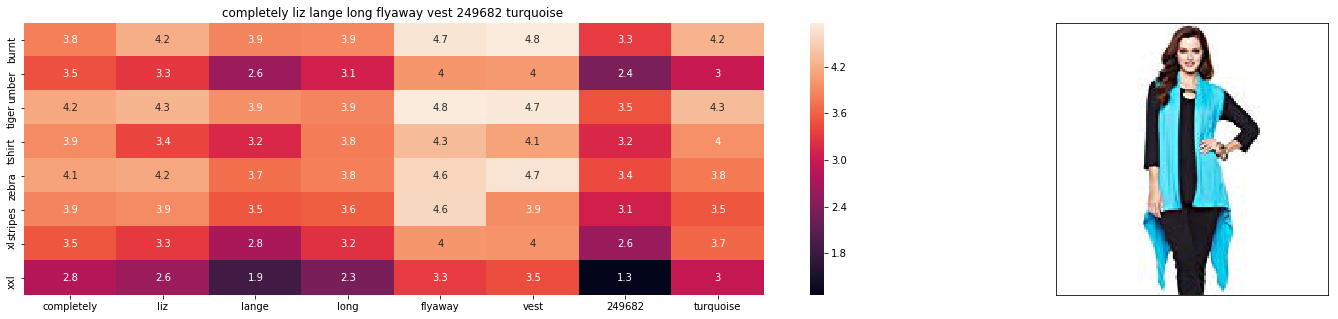

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074LTBWSW
Brand : Liz Lange
euclidean distance from input : 14.513227717322623


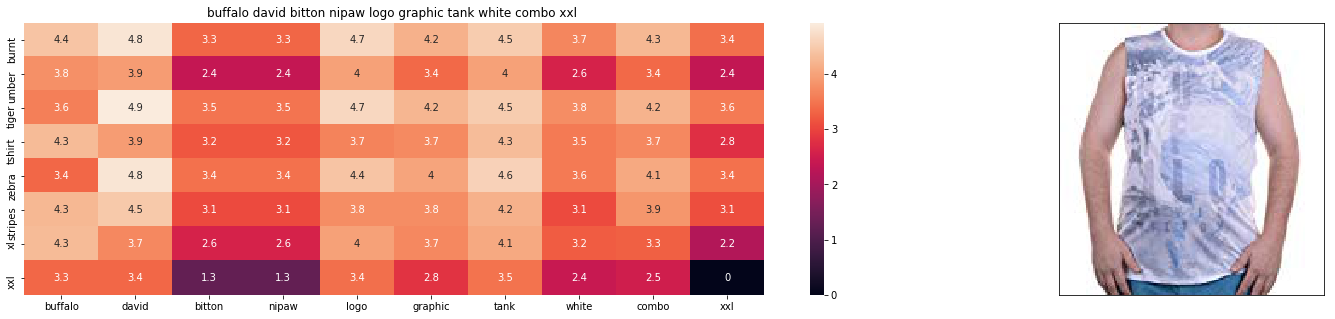

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B018H5AZXQ
Brand : Buffalo
euclidean distance from input : 14.520049921912467


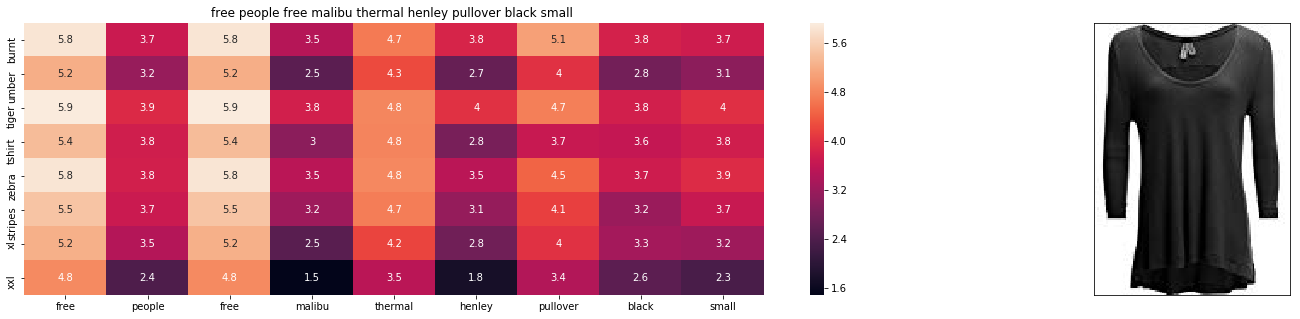

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MXY984
Brand : We The Free
euclidean distance from input : 14.669214757283529


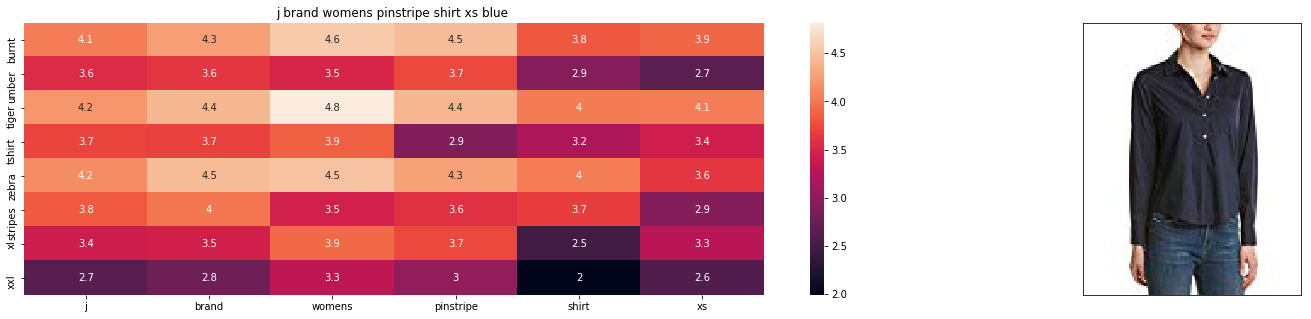

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XYP1X1F
Brand : J Brand Jeans
euclidean distance from input : 14.689343503249079


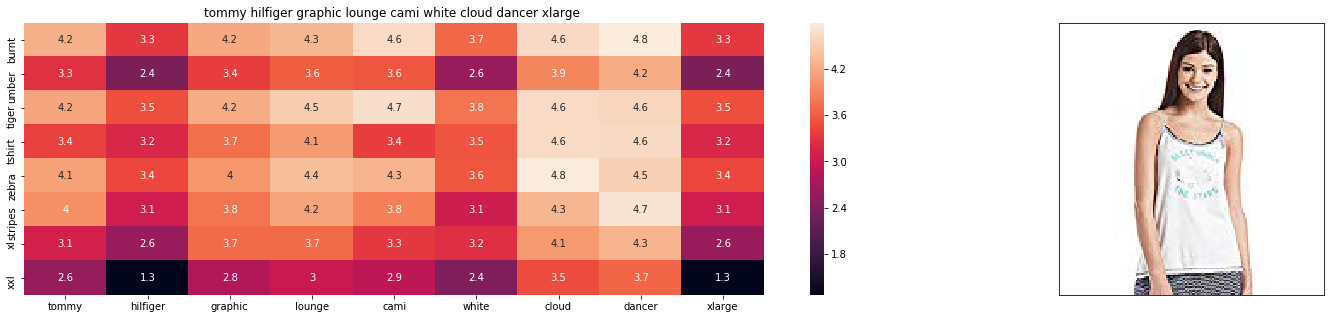

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01BMSFYW2
Brand : igertommy hilf
euclidean distance from input : 14.74332693729042


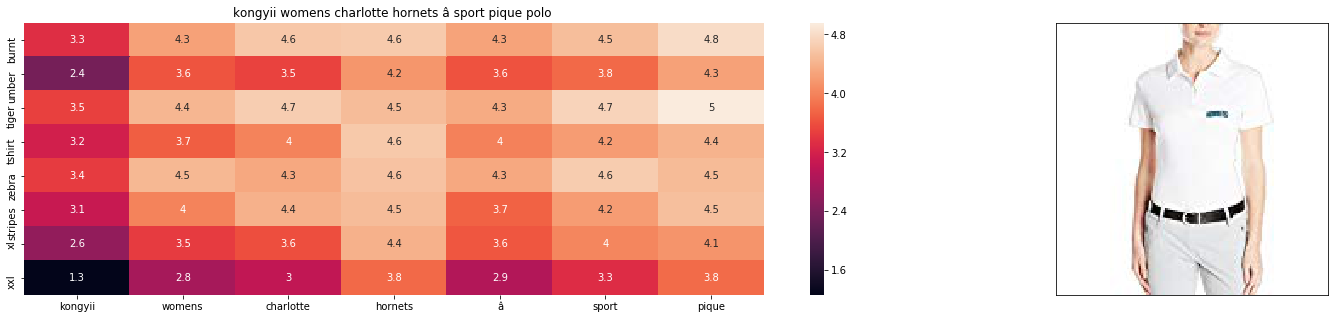

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01FJVZST2
Brand : KONGYII
euclidean distance from input : 14.975833424488977


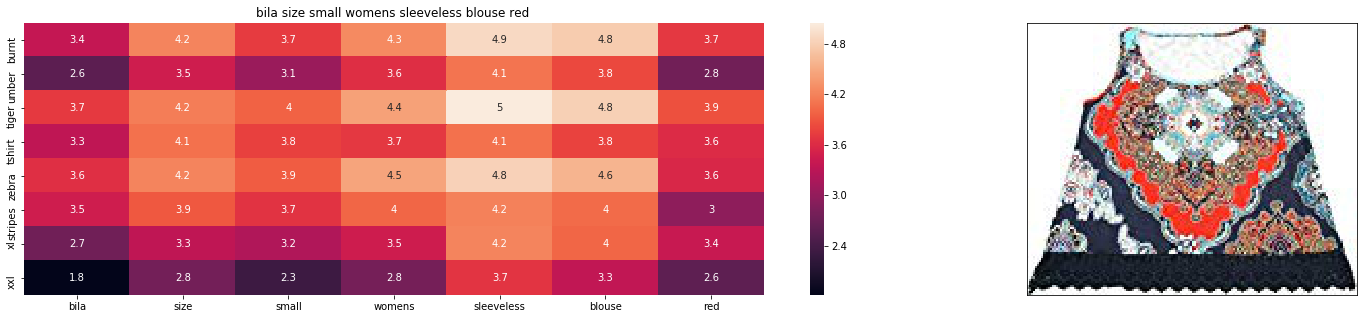

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L7ROZNC
Brand : Bila
euclidean distance from input : 15.049858801126755


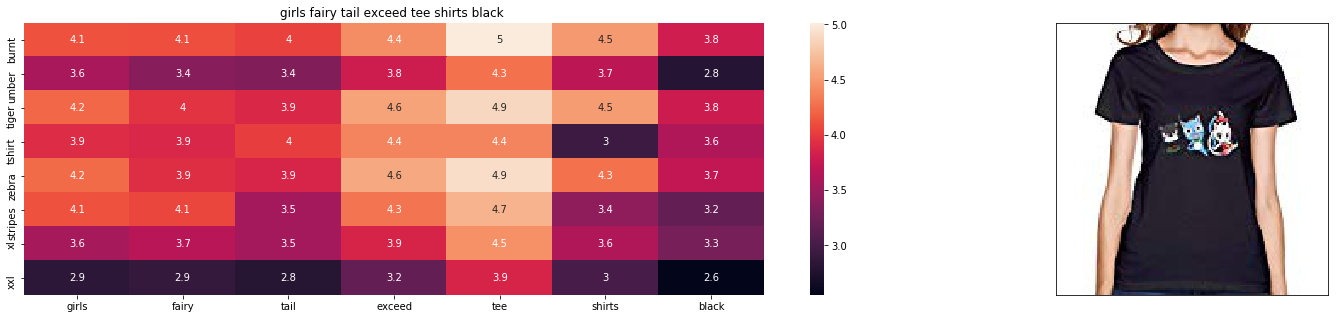

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L9F153U
Brand : ATYPEMX
euclidean distance from input : 15.209702532053267


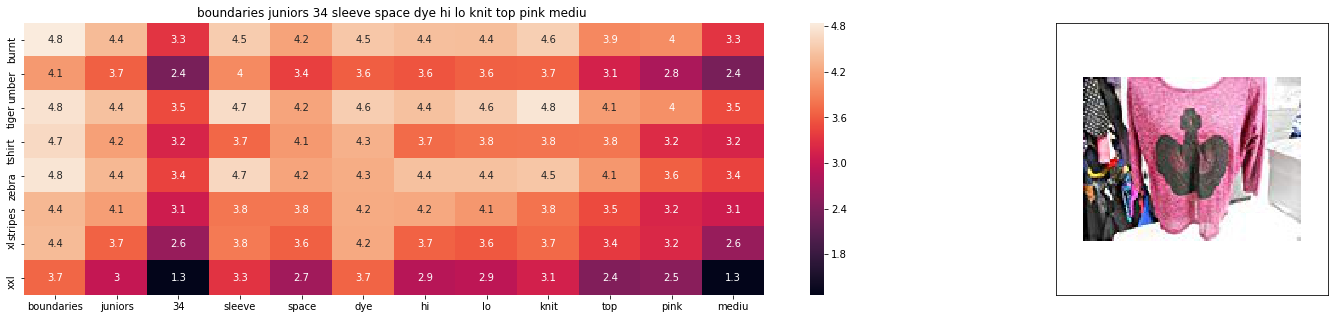

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01EXXFS4M
Brand : No Boundaries
euclidean distance from input : 15.285579173011099


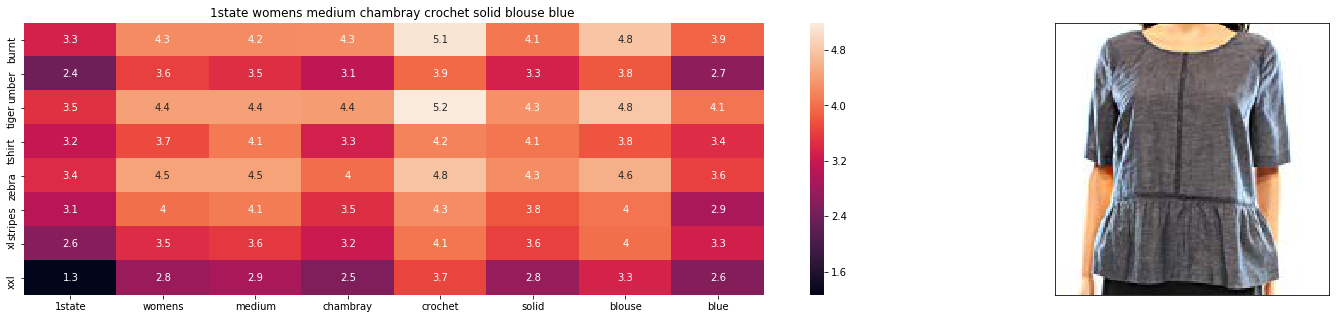

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MK6LV2
Brand : 1.State
euclidean distance from input : 15.38623063619959


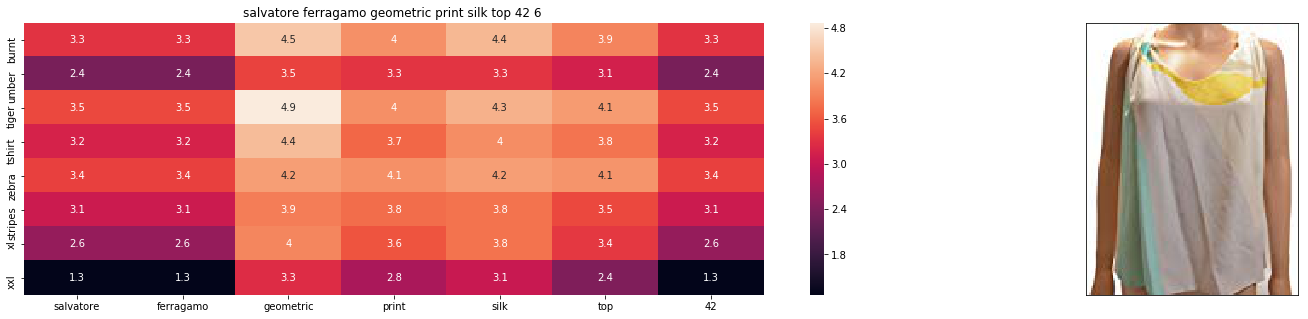

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B0756JTS1F
Brand : Salvatore Ferragamo
euclidean distance from input : 15.42541364034017


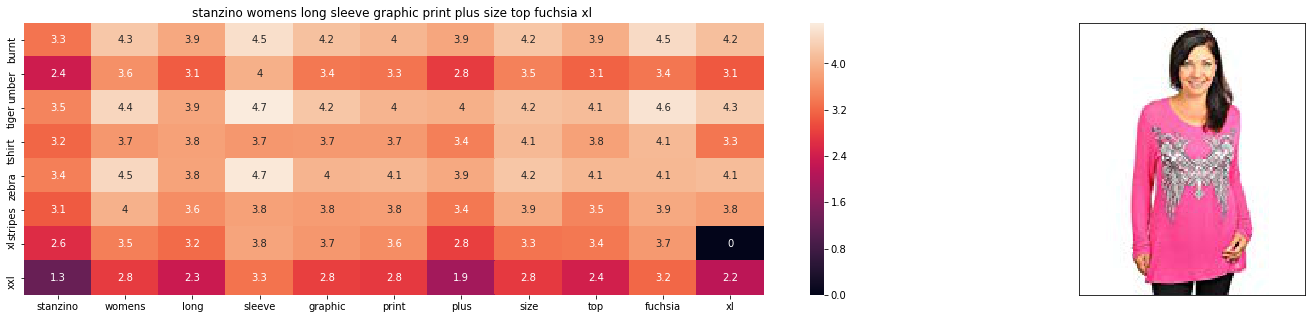

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00DP4VHWI
Brand : Stanzino
euclidean distance from input : 15.433260195017136


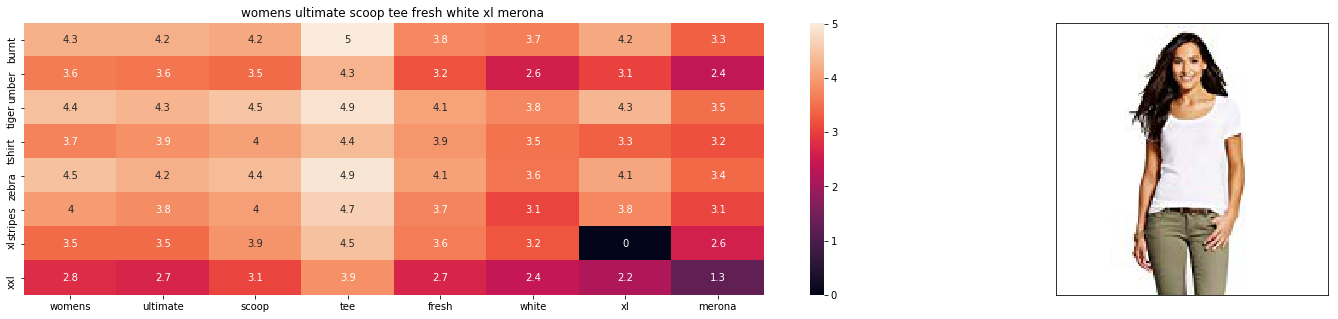

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01G7XE50E
Brand : Merona
euclidean distance from input : 15.459701069752649


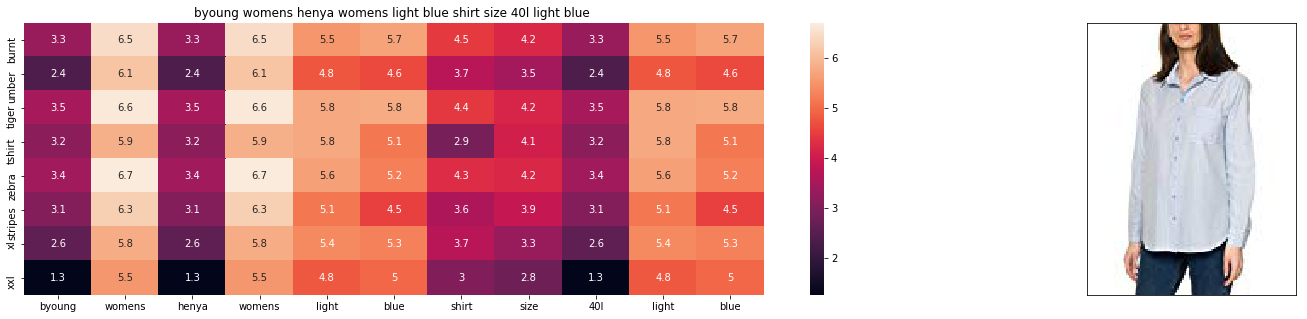

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06Y41MRCH
Brand : Byoung
euclidean distance from input : 15.535830052934603


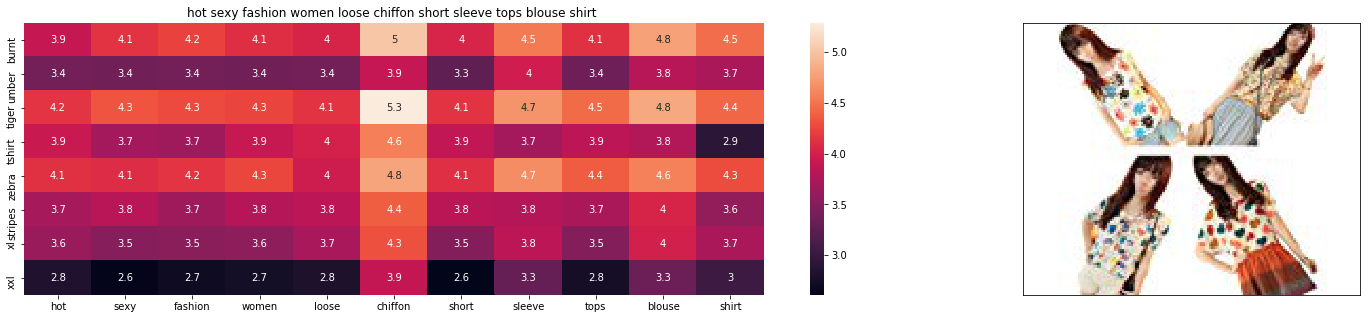

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JMAASRO
Brand : Wotefusi
euclidean distance from input : 15.535873962005253


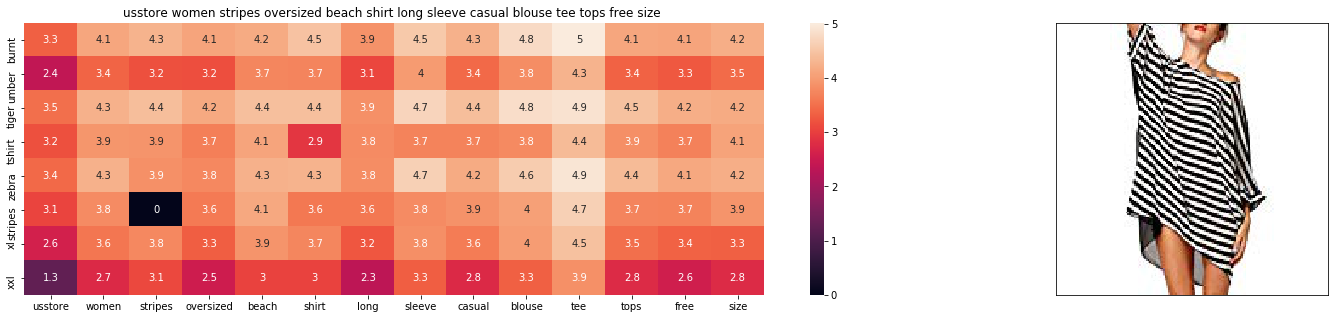

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01DNNI1RO
Brand : Usstore
euclidean distance from input : 15.58040266061079


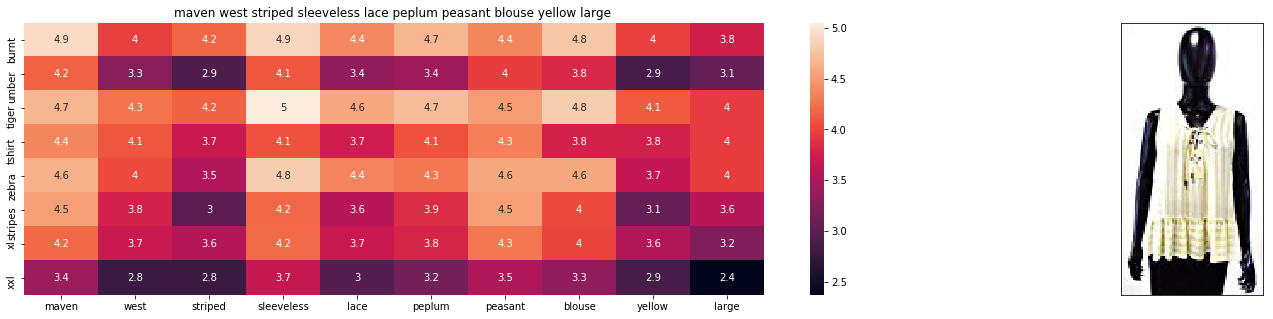

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01M8GB3AL
Brand : Maven West
euclidean distance from input : 15.580928039791699


In [88]:
idf_w2v_brand(doc_id=12566, idf_wt=5, ex_feat_wt=5, image_feat_wt=5, num_results=20)

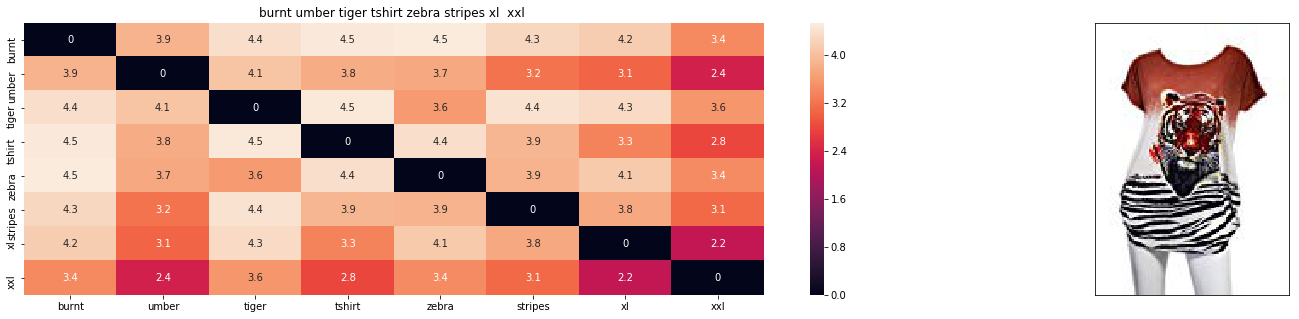

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


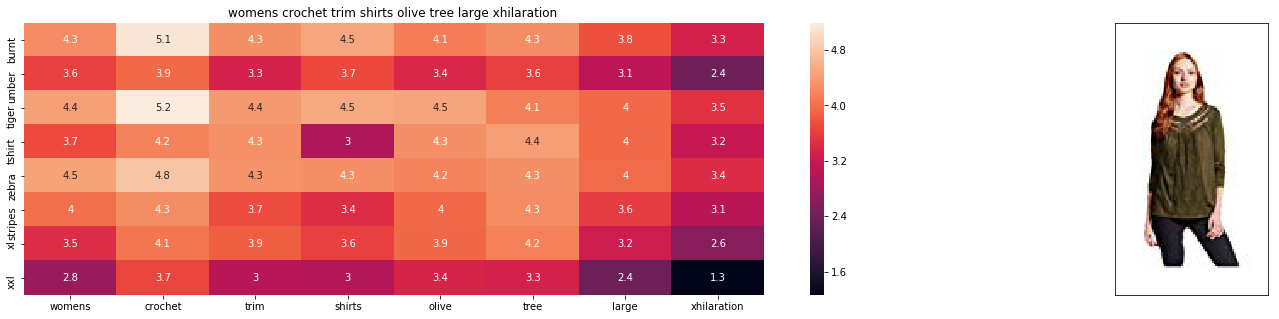

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XBHNM7J
Brand : Xhilaration
euclidean distance from input : 10.709538746060815


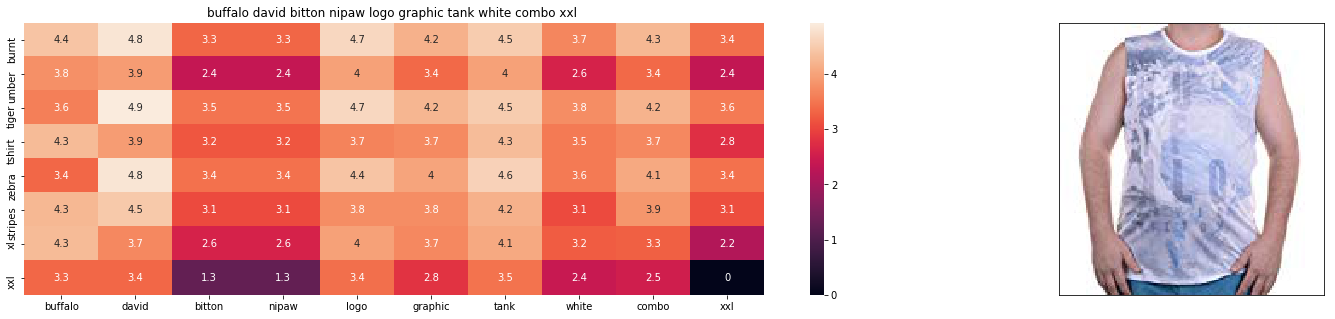

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B018H5AZXQ
Brand : Buffalo
euclidean distance from input : 11.182450676145043


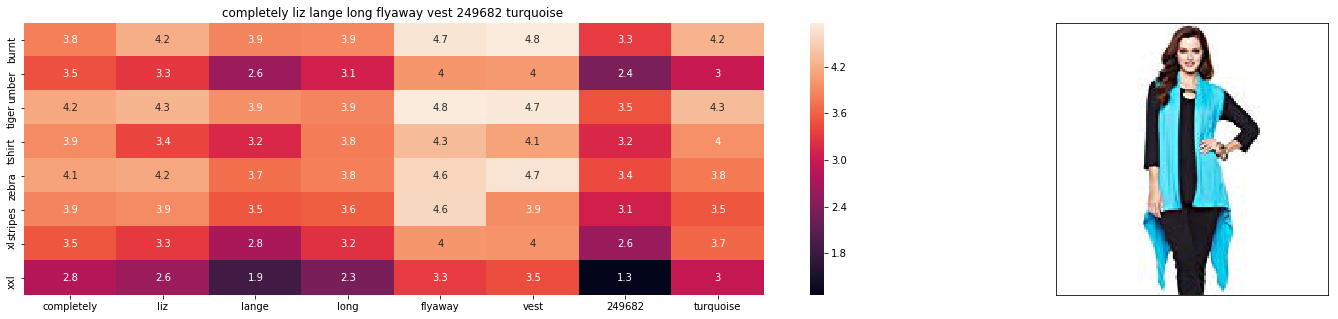

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074LTBWSW
Brand : Liz Lange
euclidean distance from input : 11.221688652219262


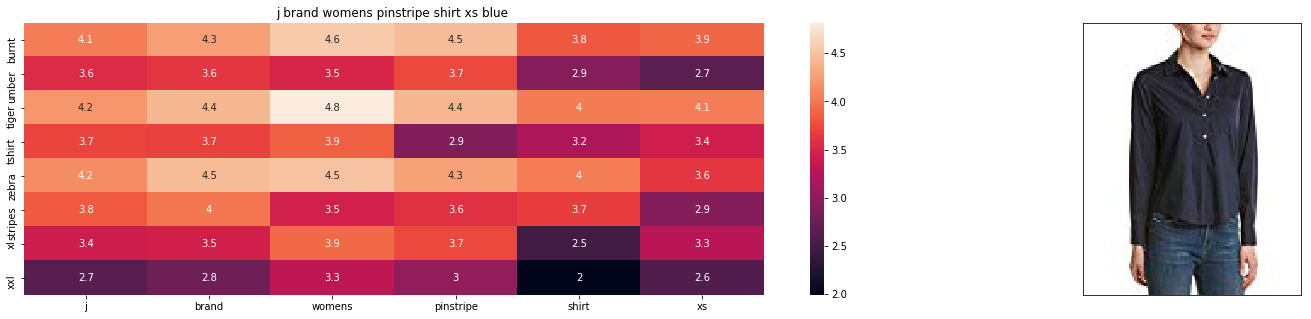

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XYP1X1F
Brand : J Brand Jeans
euclidean distance from input : 11.345803322741679


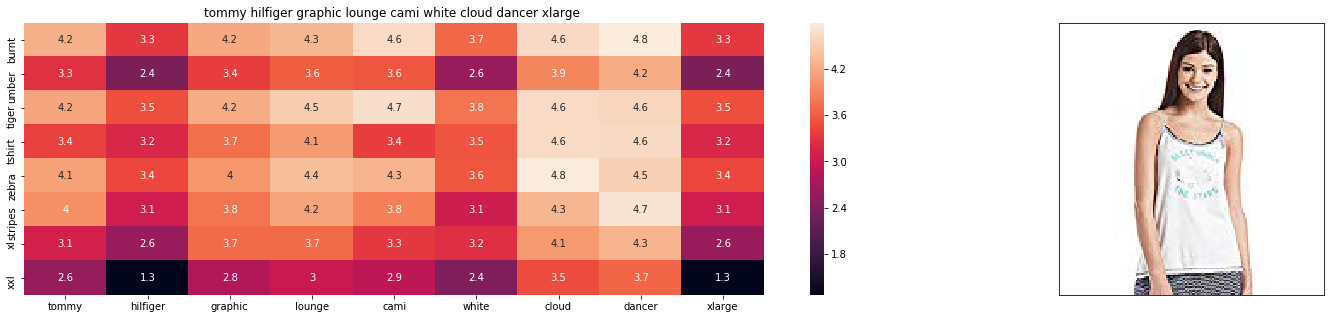

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01BMSFYW2
Brand : igertommy hilf
euclidean distance from input : 11.391014923999004


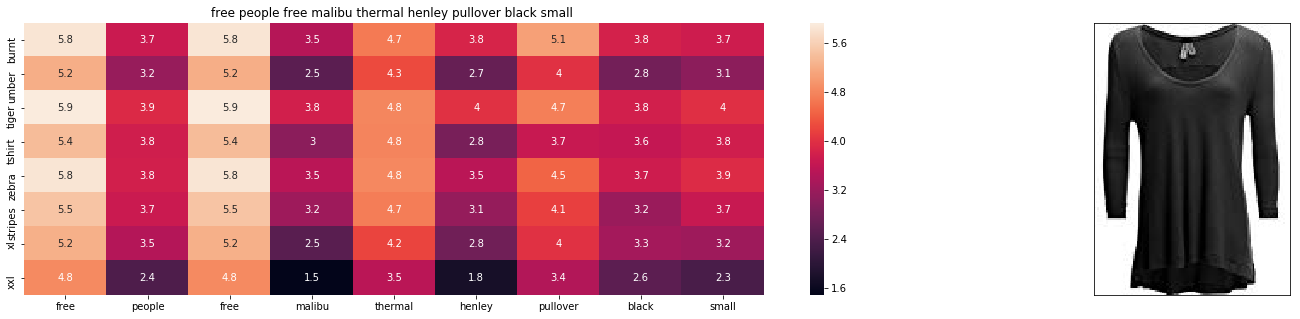

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MXY984
Brand : We The Free
euclidean distance from input : 11.412775993347168


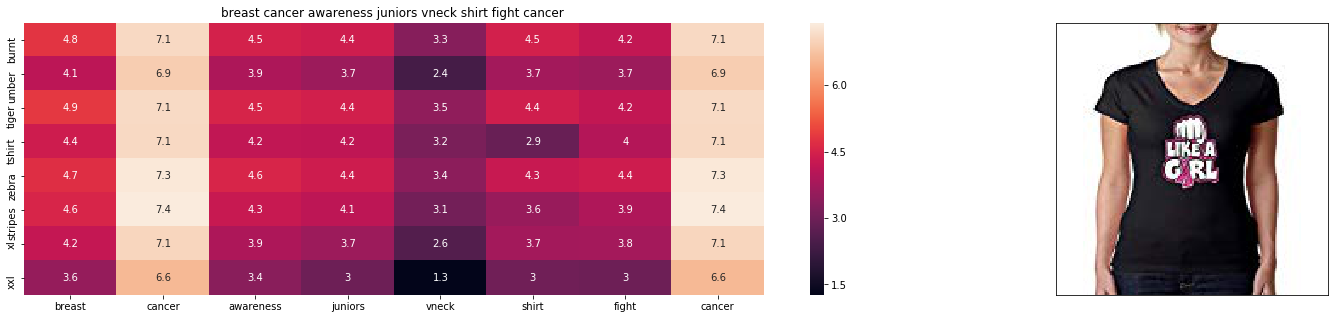

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B016CU40IY
Brand : Juiceclouds
euclidean distance from input : 11.432621032417027


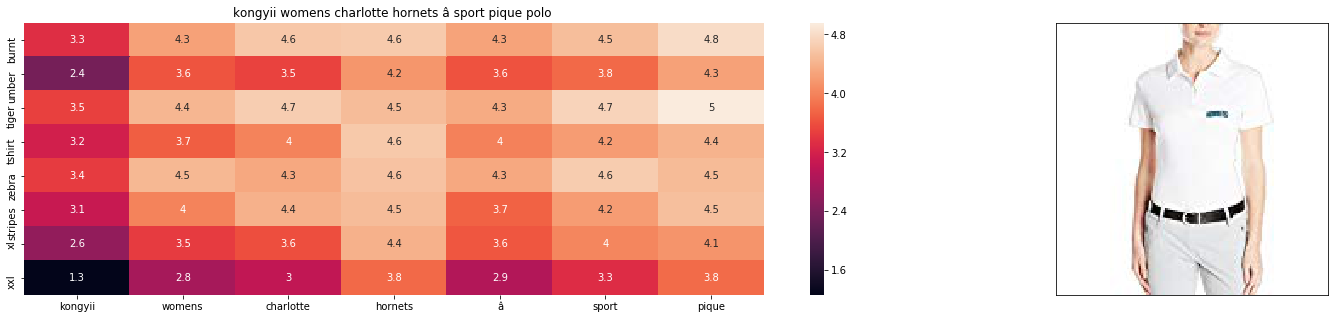

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01FJVZST2
Brand : KONGYII
euclidean distance from input : 11.620421439826695


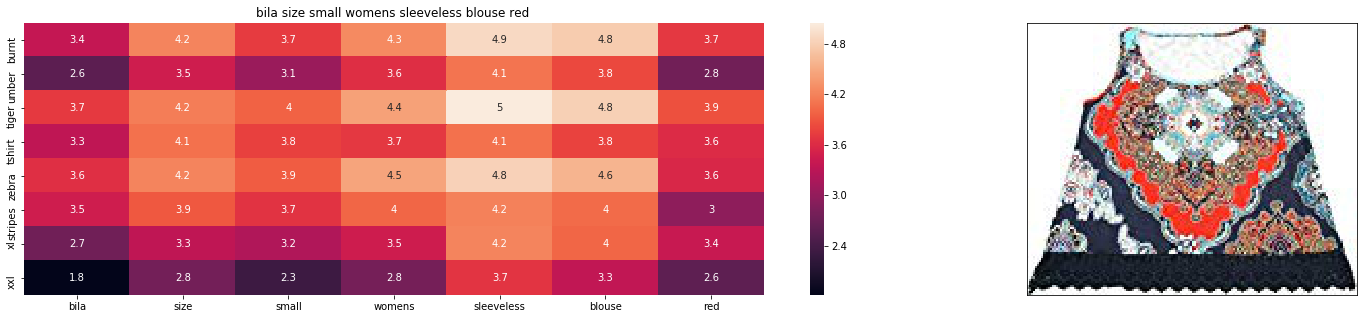

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L7ROZNC
Brand : Bila
euclidean distance from input : 11.654240876853672


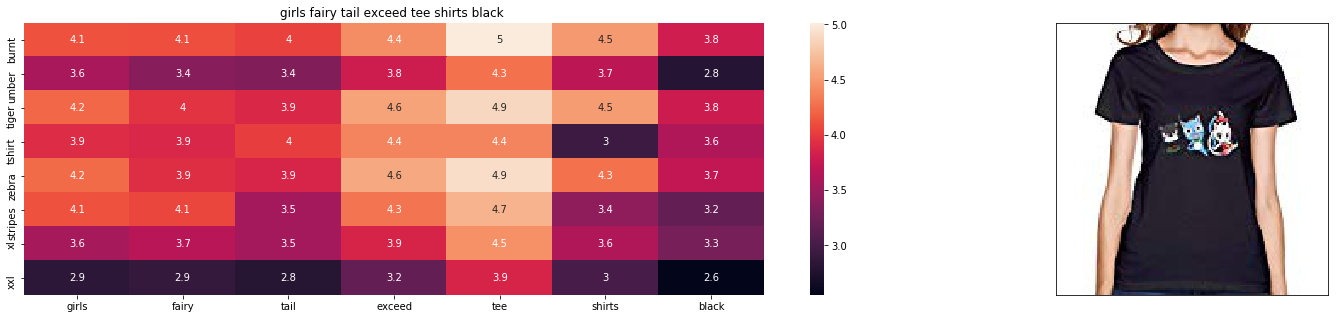

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L9F153U
Brand : ATYPEMX
euclidean distance from input : 11.756462985694615


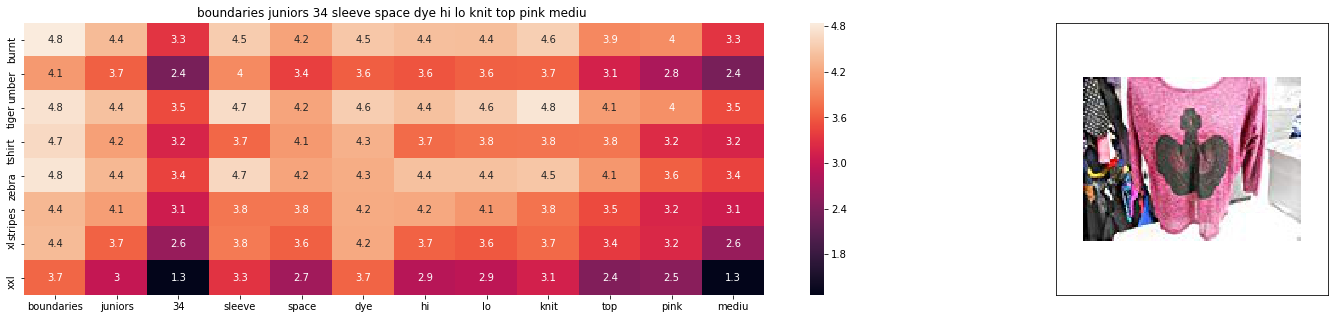

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01EXXFS4M
Brand : No Boundaries
euclidean distance from input : 11.7987392427344


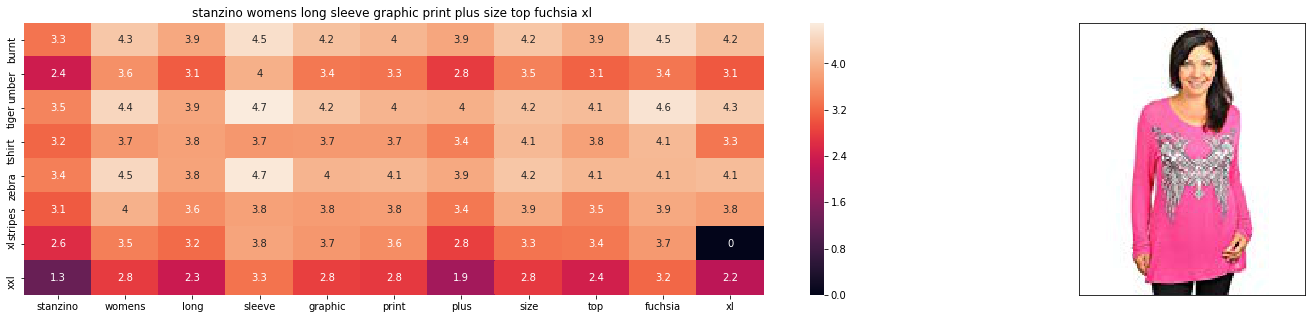

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00DP4VHWI
Brand : Stanzino
euclidean distance from input : 11.894349986732212


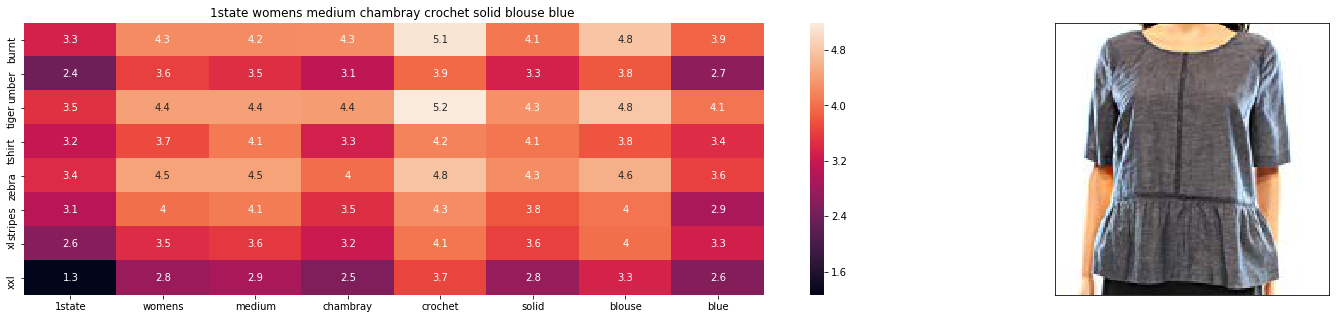

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MK6LV2
Brand : 1.State
euclidean distance from input : 11.905540877998082


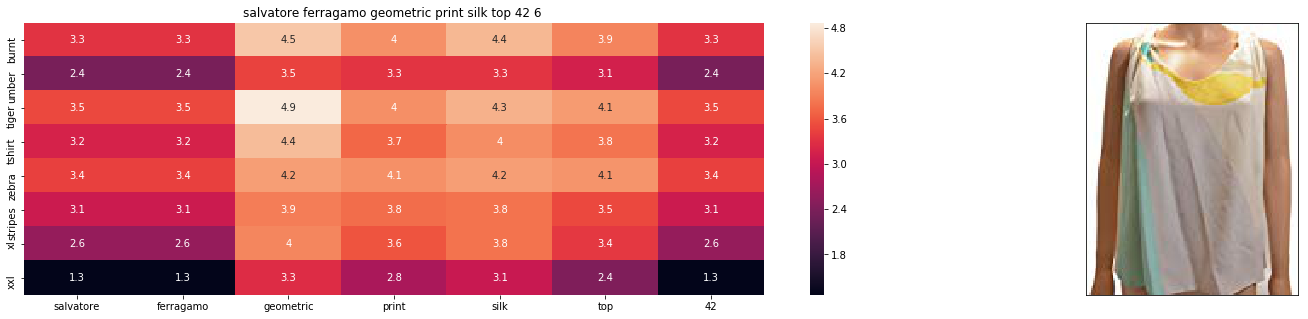

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B0756JTS1F
Brand : Salvatore Ferragamo
euclidean distance from input : 11.920426368713379


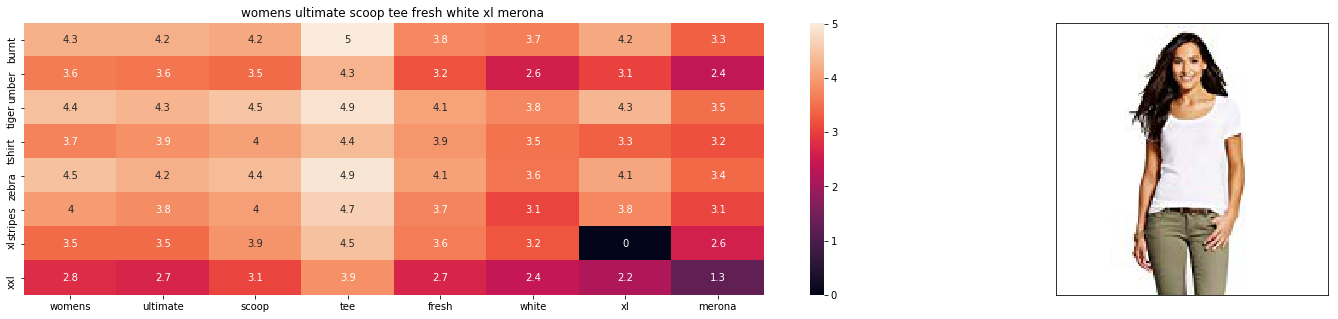

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01G7XE50E
Brand : Merona
euclidean distance from input : 11.927068549812045


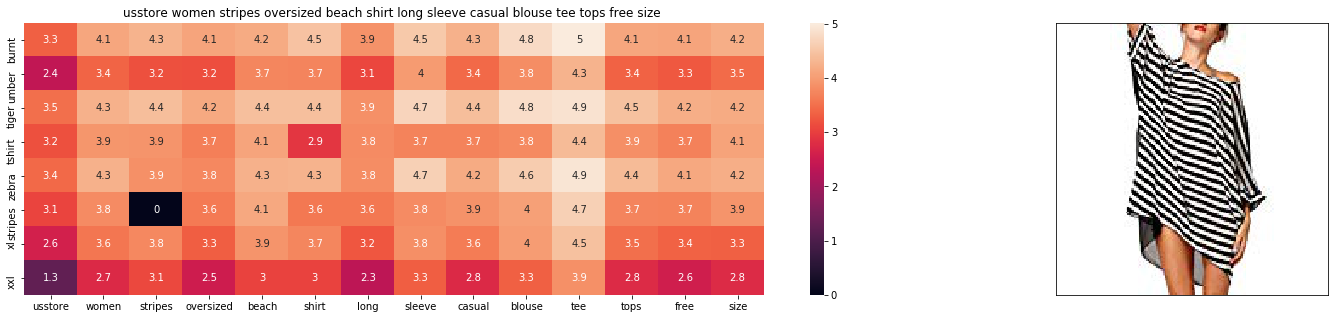

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01DNNI1RO
Brand : Usstore
euclidean distance from input : 12.016570329846825


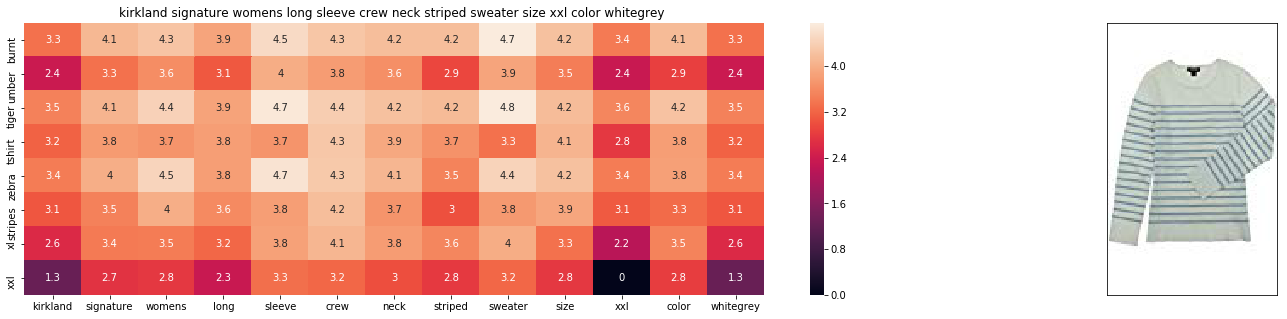

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XTPC3FP
Brand : Kirkland Signature
euclidean distance from input : 12.039993000211206


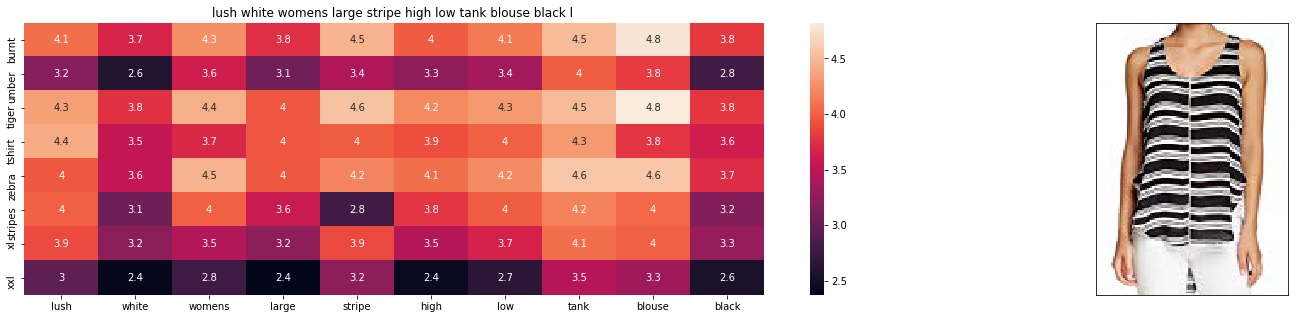

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B07285DZ7S
Brand : Lush Clothing
euclidean distance from input : 12.04091773051211


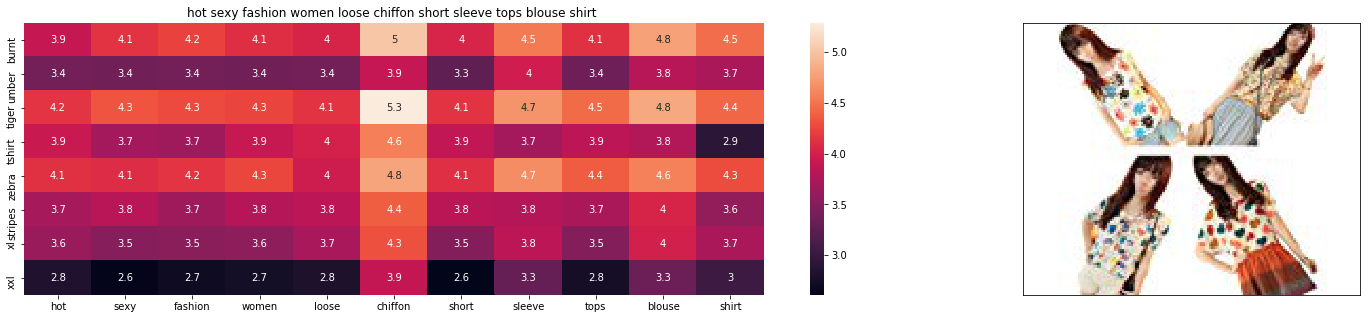

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JMAASRO
Brand : Wotefusi
euclidean distance from input : 12.040963203132359


In [89]:
idf_w2v_brand(doc_id=12566, idf_wt=10, ex_feat_wt=5, image_feat_wt=5, num_results=20)

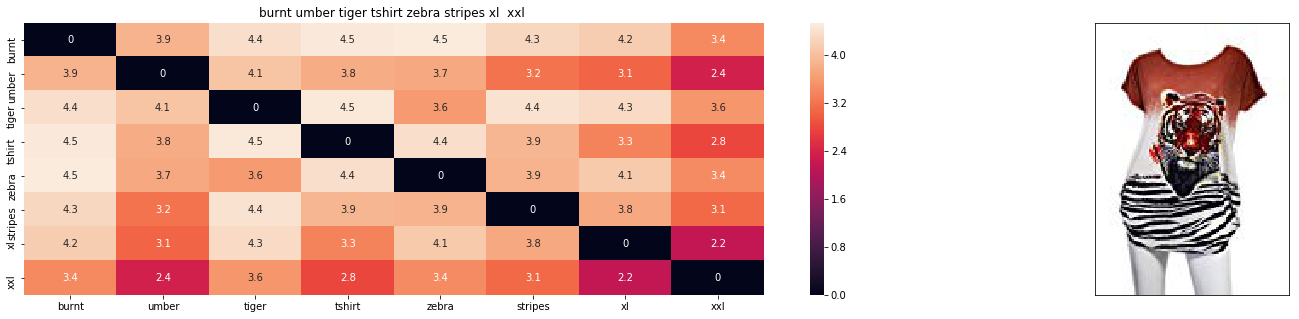

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


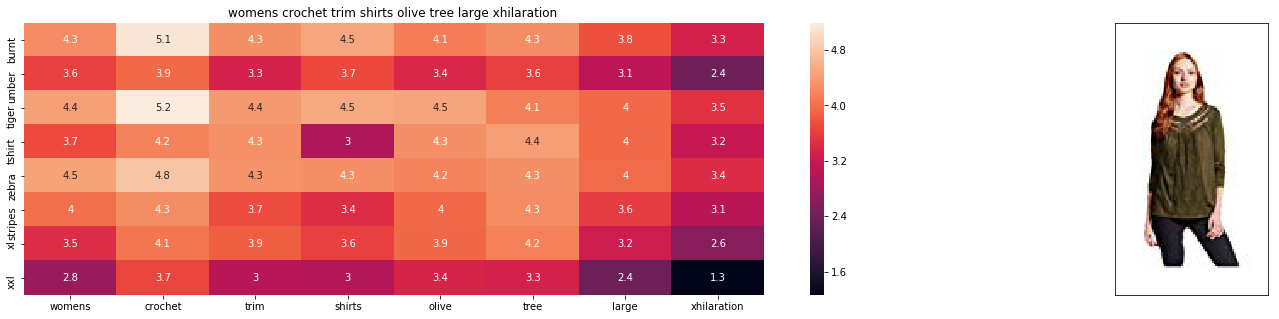

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XBHNM7J
Brand : Xhilaration
euclidean distance from input : 11.06390671766179


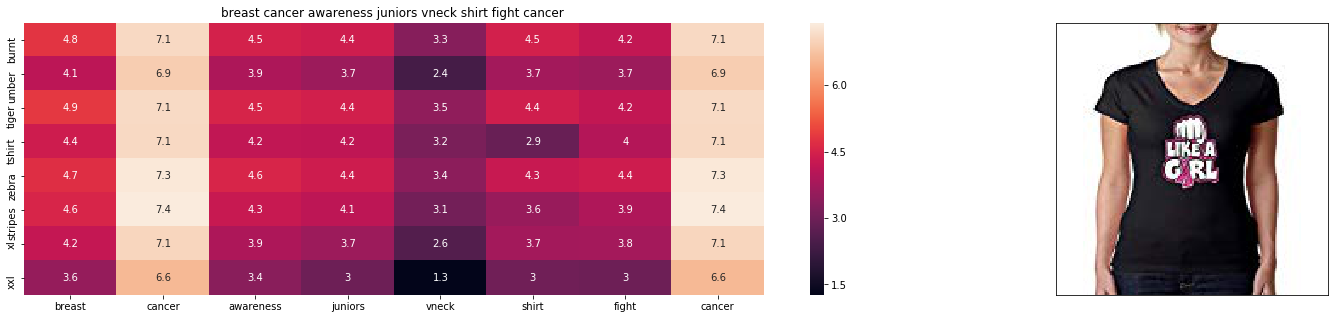

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B016CU40IY
Brand : Juiceclouds
euclidean distance from input : 11.497610629439766


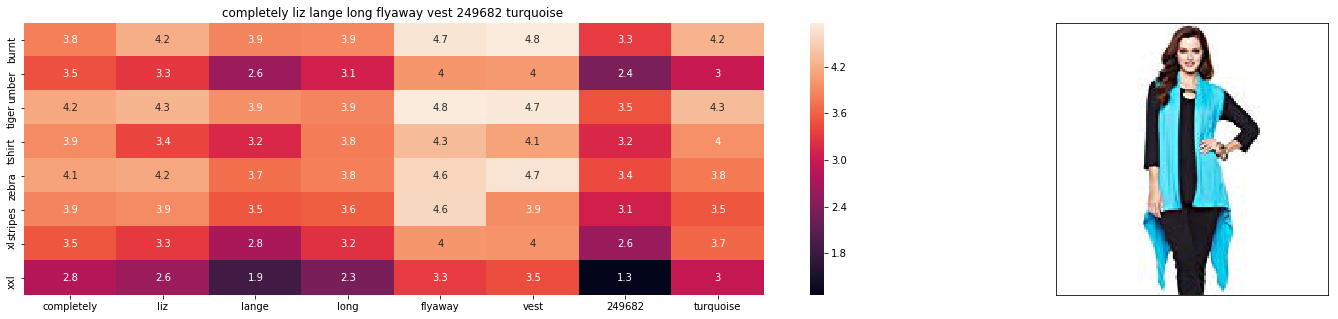

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074LTBWSW
Brand : Liz Lange
euclidean distance from input : 11.592027569178516


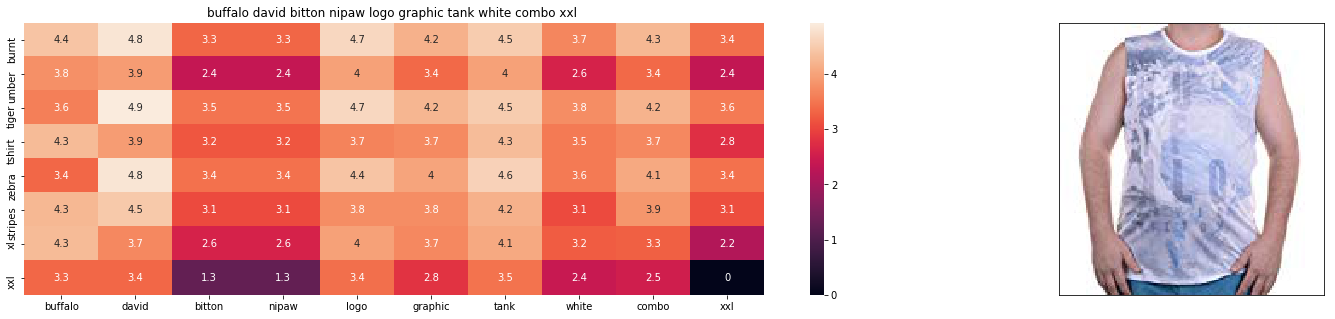

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B018H5AZXQ
Brand : Buffalo
euclidean distance from input : 11.597144222620898


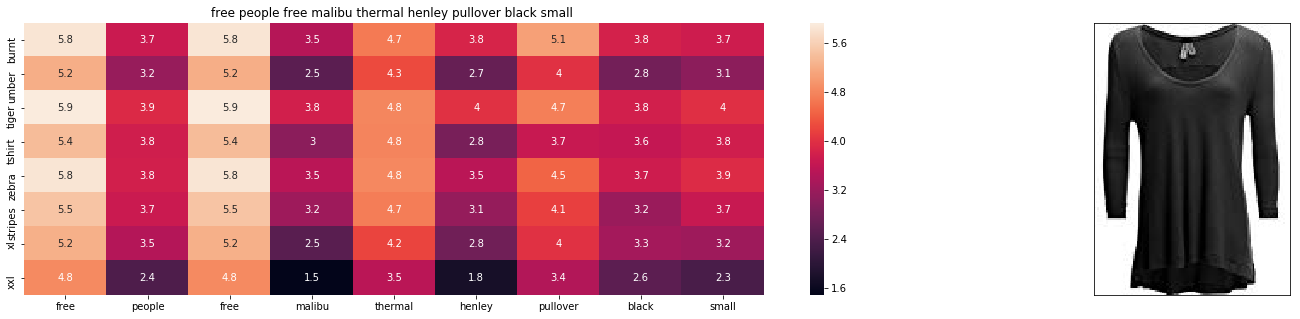

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MXY984
Brand : We The Free
euclidean distance from input : 11.751911067962647


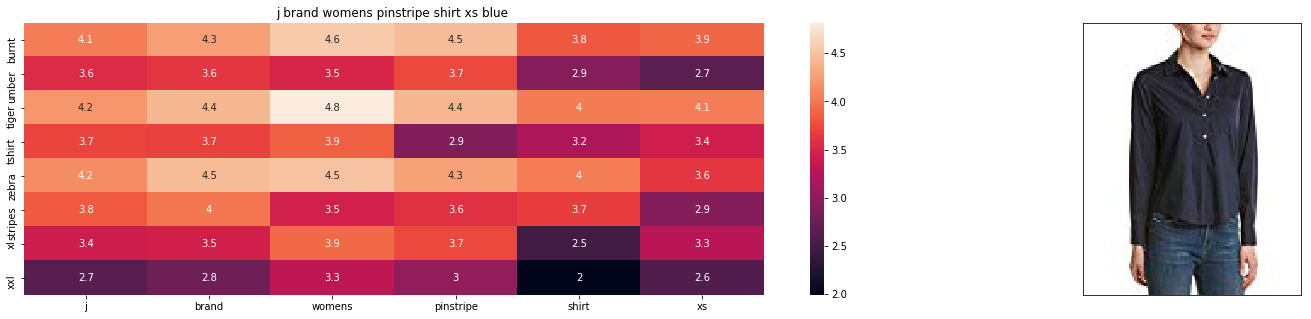

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XYP1X1F
Brand : J Brand Jeans
euclidean distance from input : 11.807577042478904


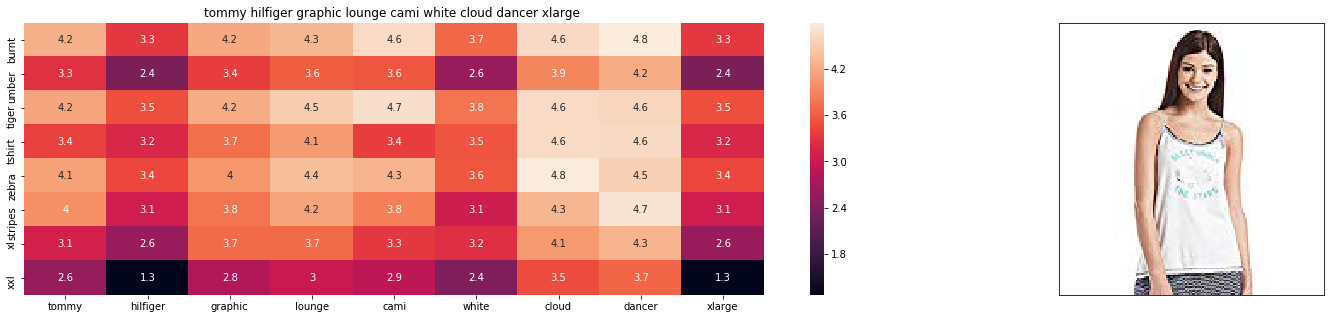

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01BMSFYW2
Brand : igertommy hilf
euclidean distance from input : 11.84806461800991


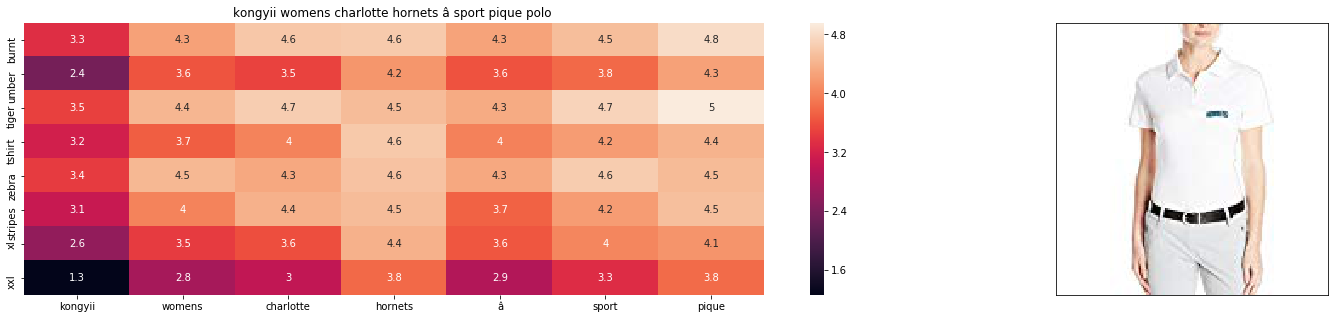

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01FJVZST2
Brand : KONGYII
euclidean distance from input : 11.89331289613288


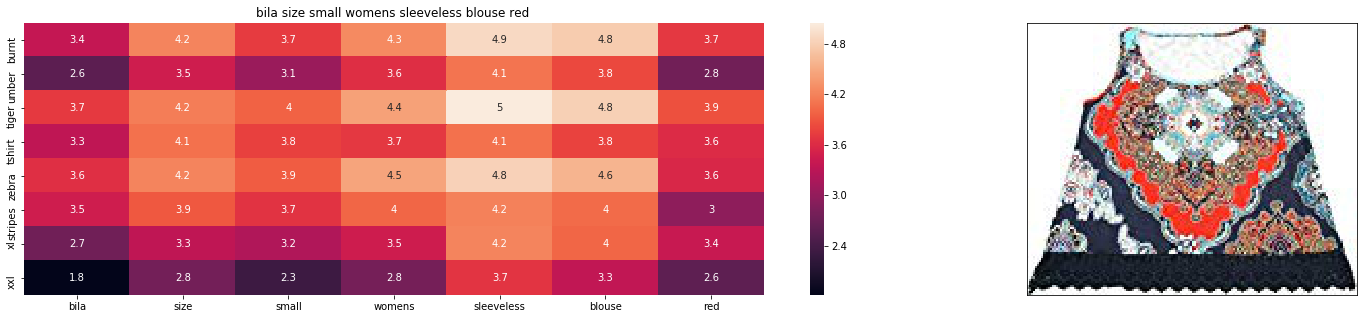

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L7ROZNC
Brand : Bila
euclidean distance from input : 11.948831928611213


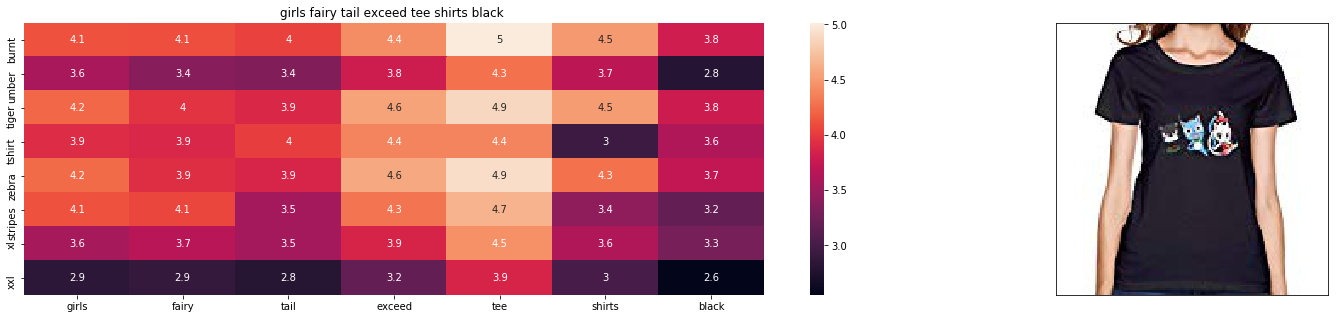

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L9F153U
Brand : ATYPEMX
euclidean distance from input : 12.068714726806098


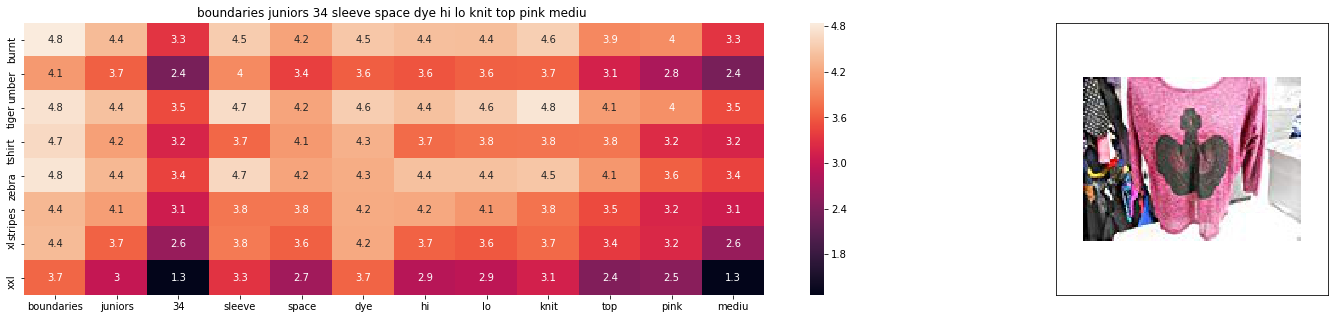

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01EXXFS4M
Brand : No Boundaries
euclidean distance from input : 12.171291160944872


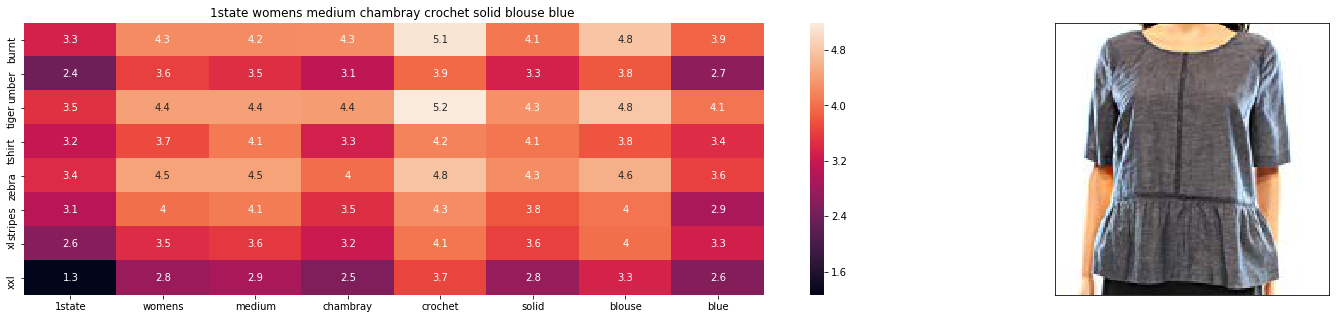

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MK6LV2
Brand : 1.State
euclidean distance from input : 12.201110804915839


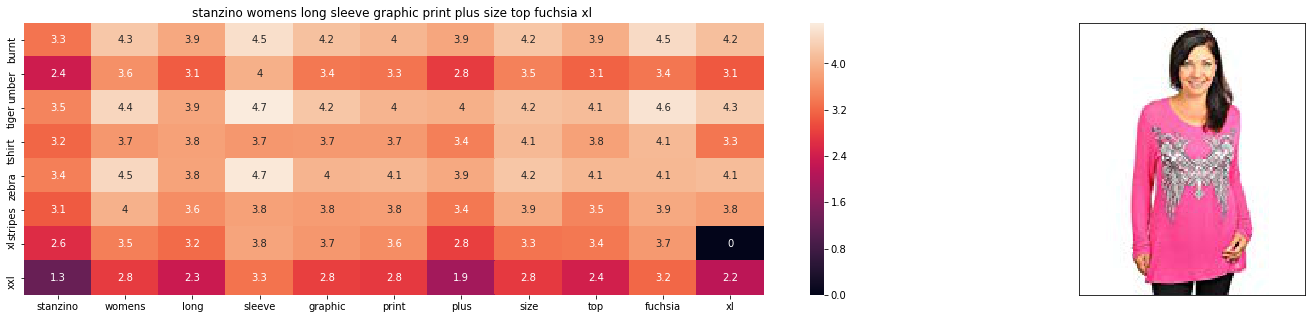

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00DP4VHWI
Brand : Stanzino
euclidean distance from input : 12.236382974028999


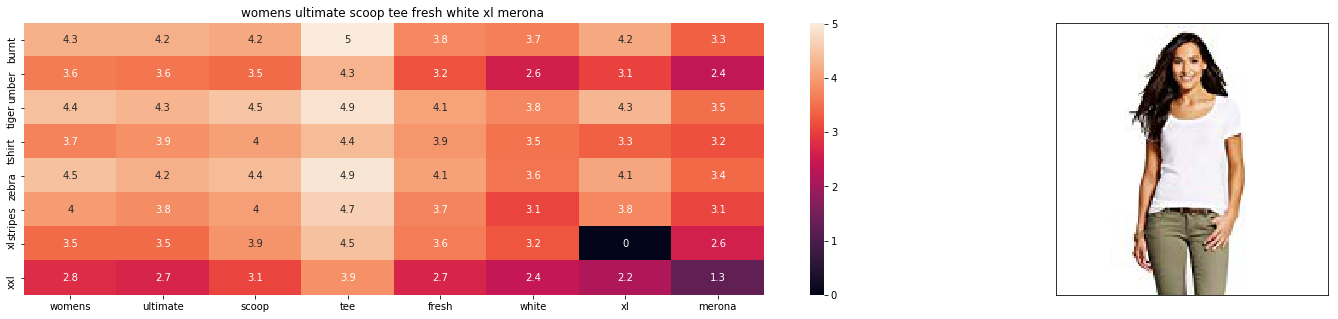

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01G7XE50E
Brand : Merona
euclidean distance from input : 12.256213630080634


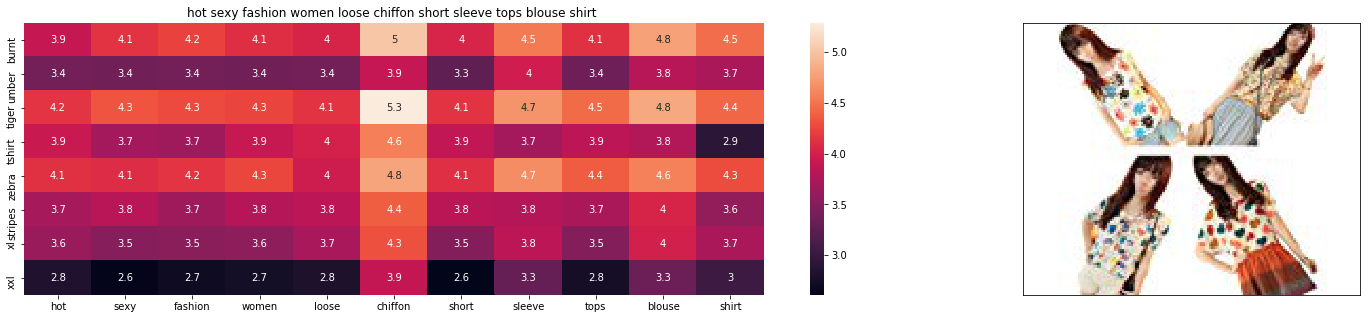

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JMAASRO
Brand : Wotefusi
euclidean distance from input : 12.313343299270088


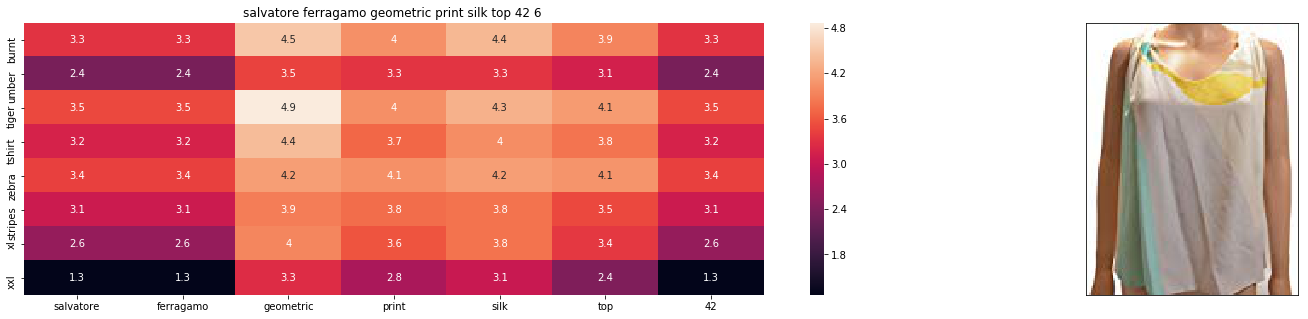

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B0756JTS1F
Brand : Salvatore Ferragamo
euclidean distance from input : 12.319060230255127


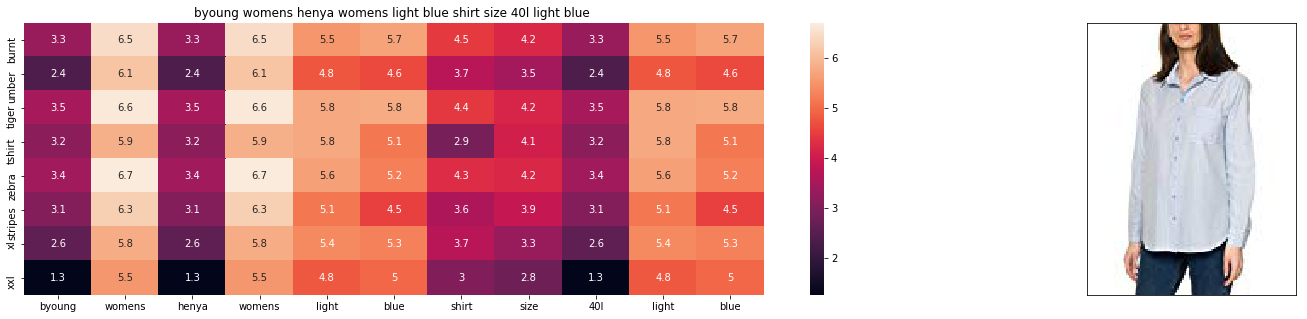

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06Y41MRCH
Brand : Byoung
euclidean distance from input : 12.3589793208875


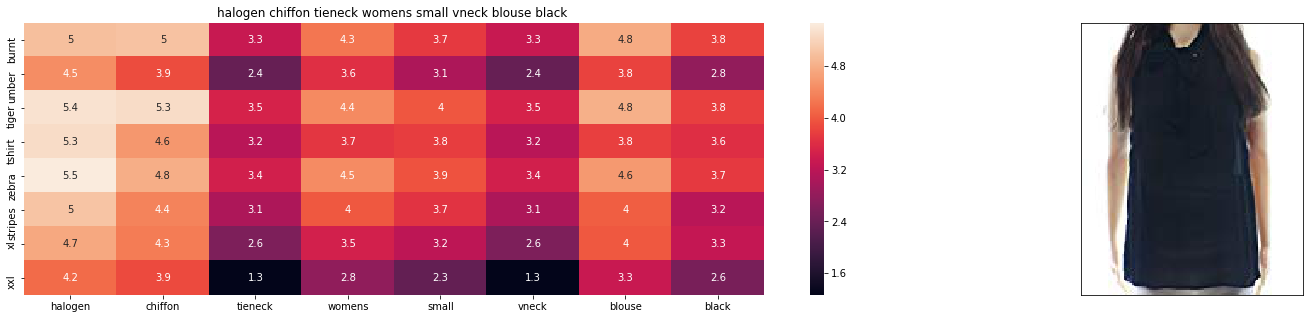

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B071VYLW1H
Brand : Halogen
euclidean distance from input : 12.391890538573676


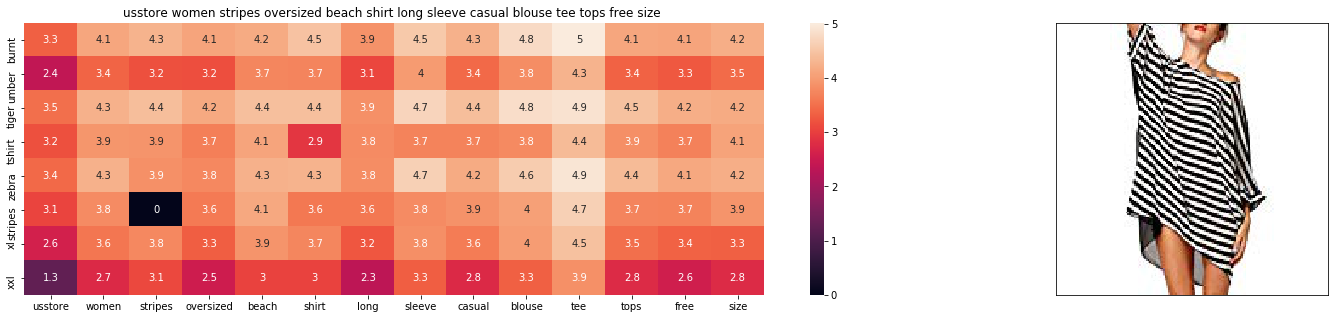

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01DNNI1RO
Brand : Usstore
euclidean distance from input : 12.39240877664464


In [90]:
idf_w2v_brand(doc_id=12566, idf_wt=5, ex_feat_wt=10, image_feat_wt=5, num_results=20)

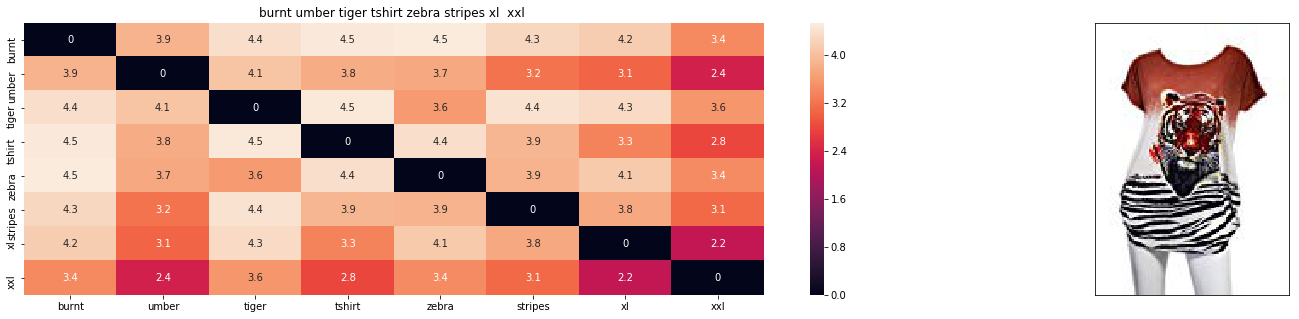

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0


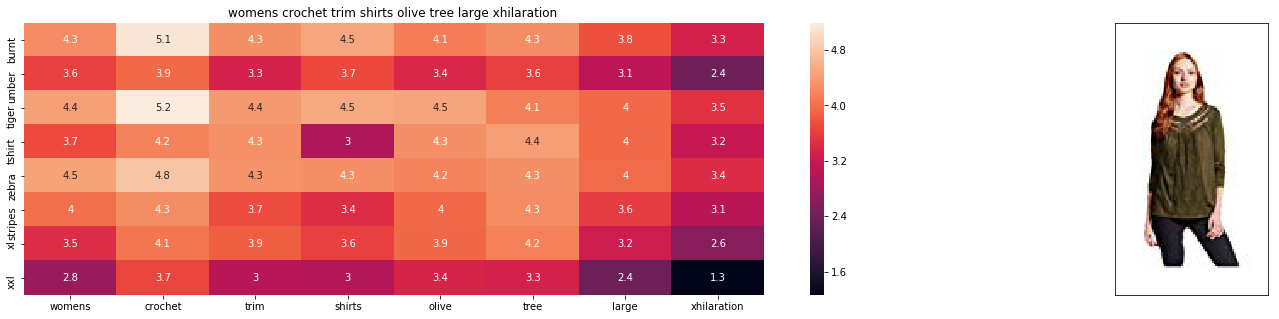

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XBHNM7J
Brand : Xhilaration
euclidean distance from input : 19.65375428217837


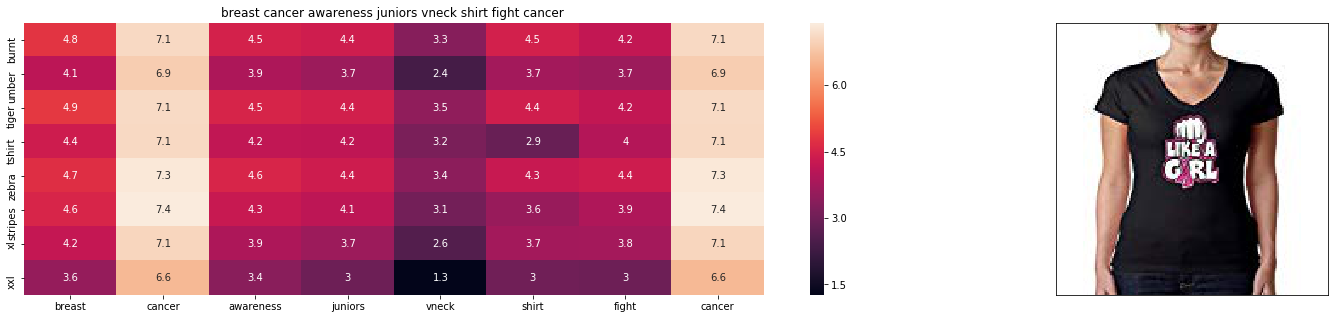

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B016CU40IY
Brand : Juiceclouds
euclidean distance from input : 20.41445954483768


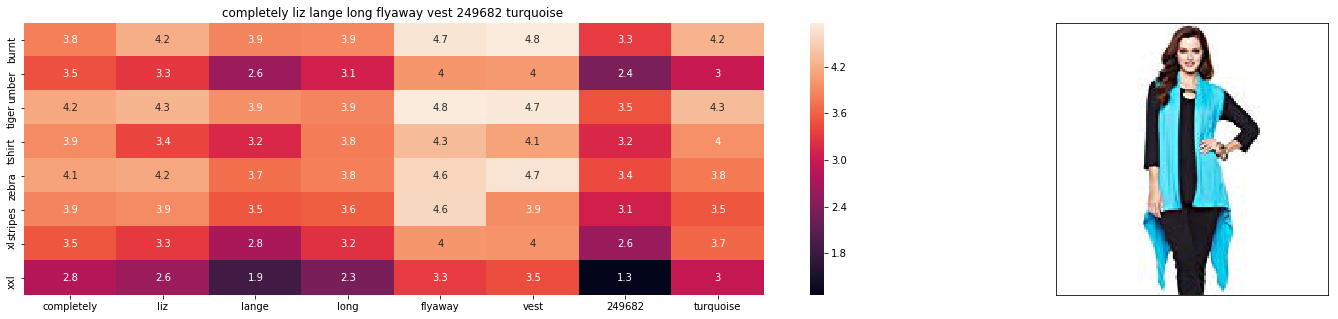

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074LTBWSW
Brand : Liz Lange
euclidean distance from input : 20.72596693057009


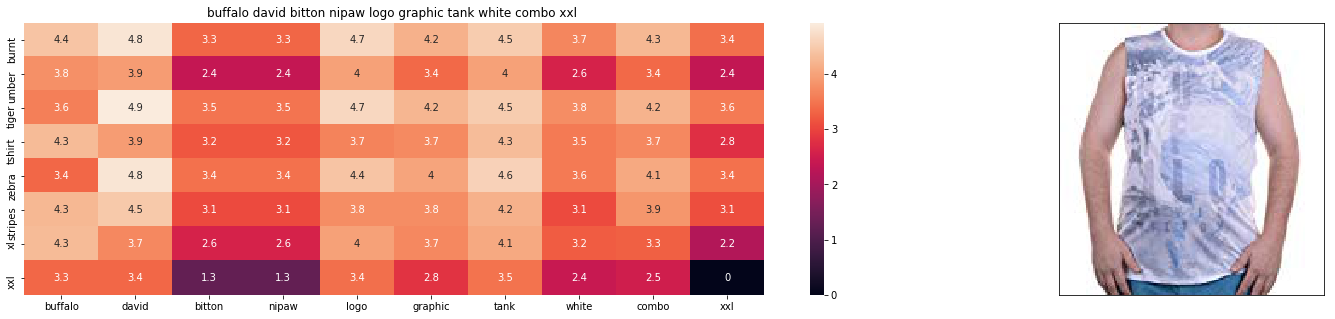

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B018H5AZXQ
Brand : Buffalo
euclidean distance from input : 20.78055486697146


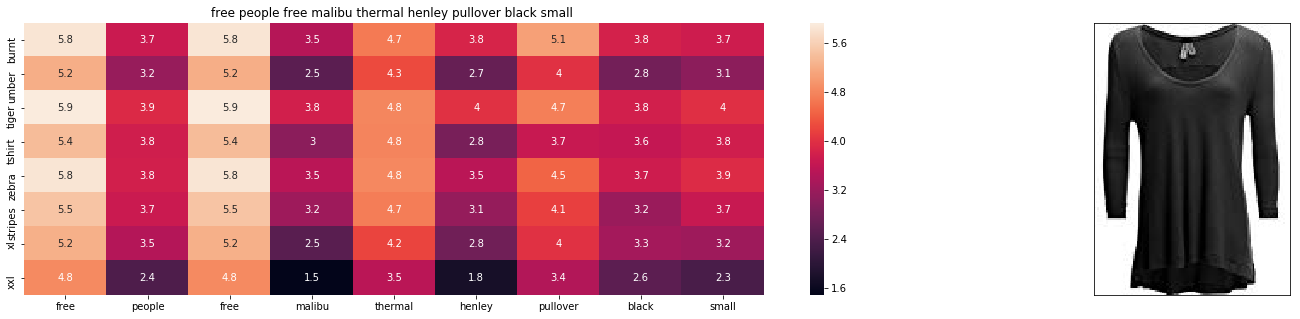

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MXY984
Brand : We The Free
euclidean distance from input : 20.84295721054077


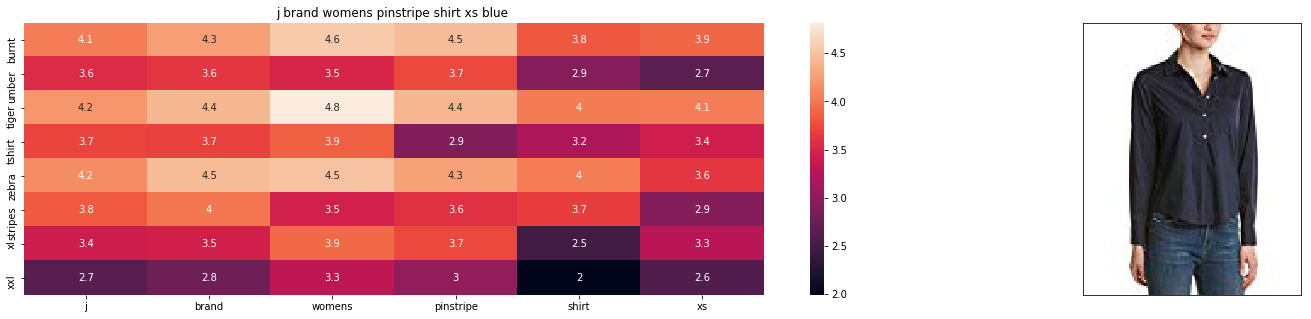

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06XYP1X1F
Brand : J Brand Jeans
euclidean distance from input : 20.914650144526654


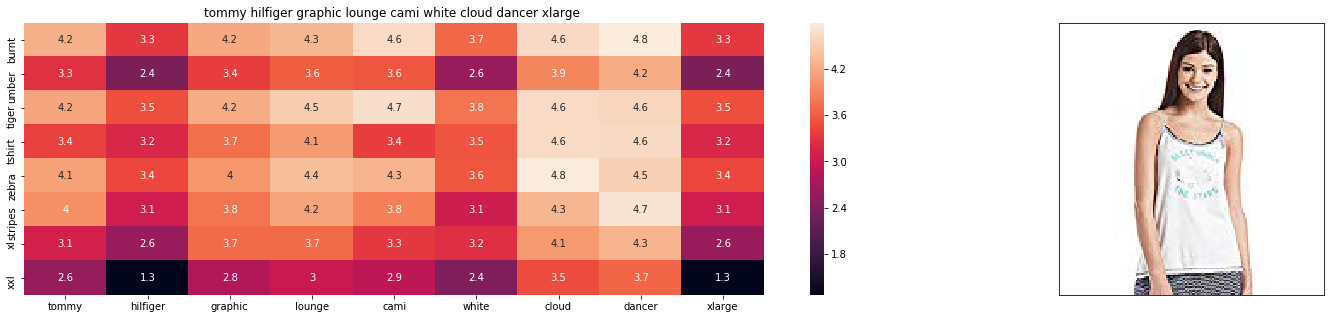

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01BMSFYW2
Brand : igertommy hilf
euclidean distance from input : 20.990901269862345


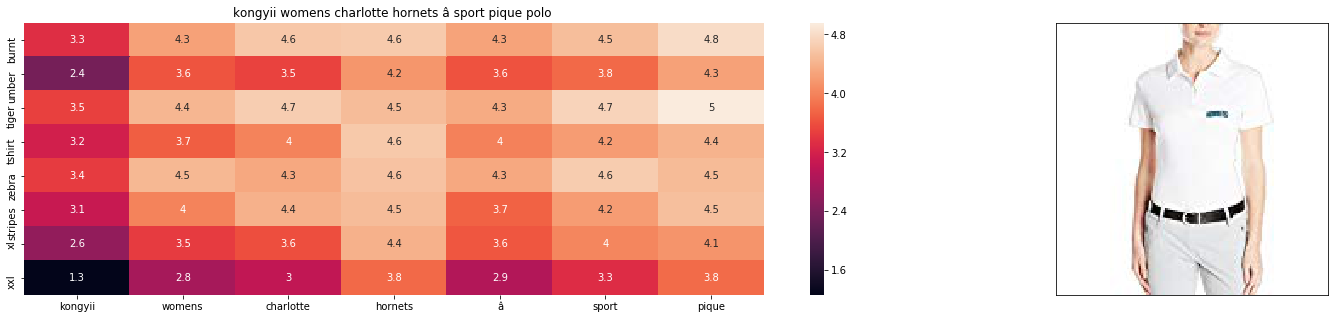

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01FJVZST2
Brand : KONGYII
euclidean distance from input : 21.413765937507357


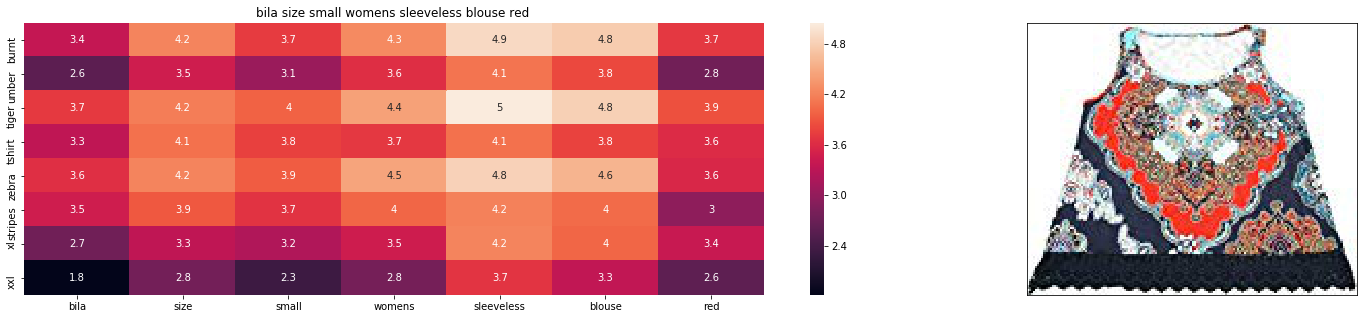

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L7ROZNC
Brand : Bila
euclidean distance from input : 21.54650359791538


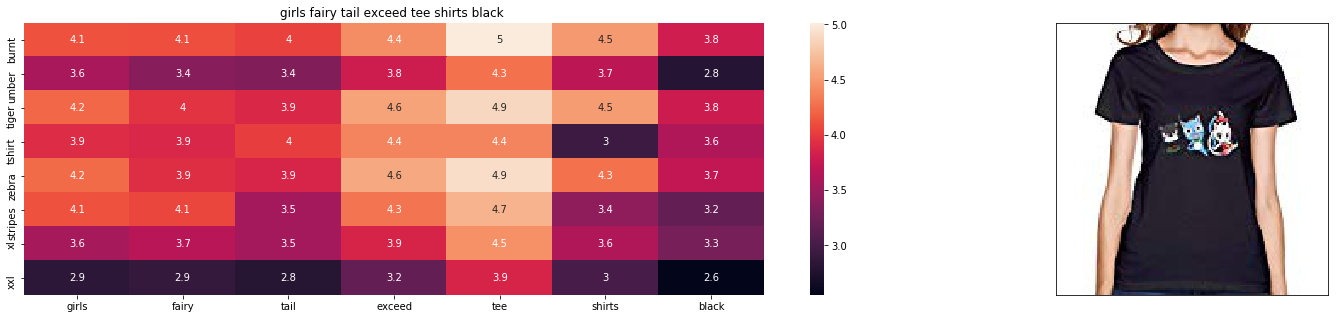

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01L9F153U
Brand : ATYPEMX
euclidean distance from input : 21.80392988365909


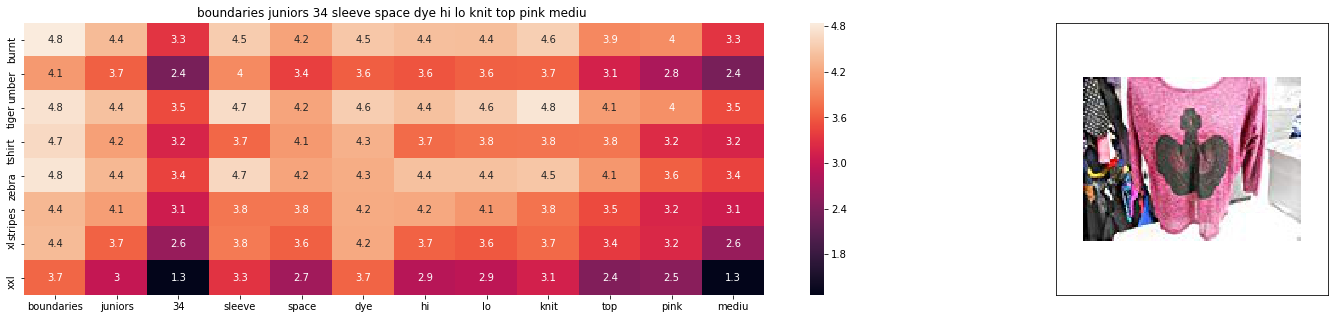

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01EXXFS4M
Brand : No Boundaries
euclidean distance from input : 21.886707115354028


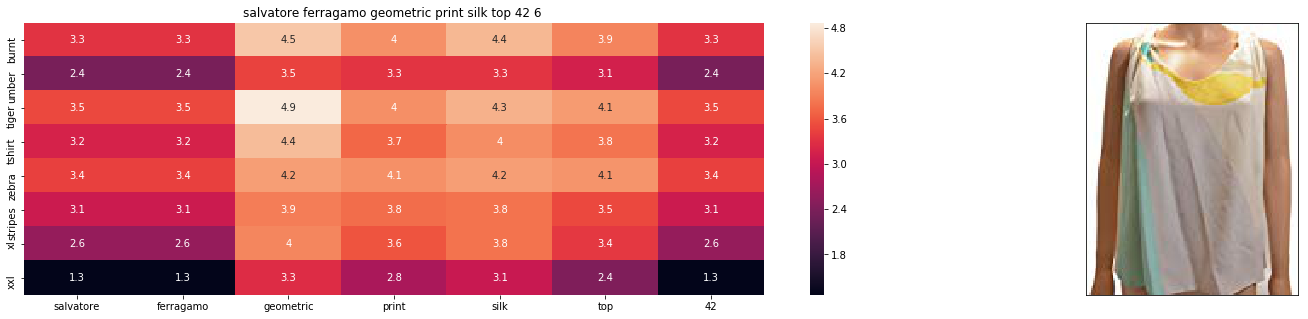

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B0756JTS1F
Brand : Salvatore Ferragamo
euclidean distance from input : 22.036754322052


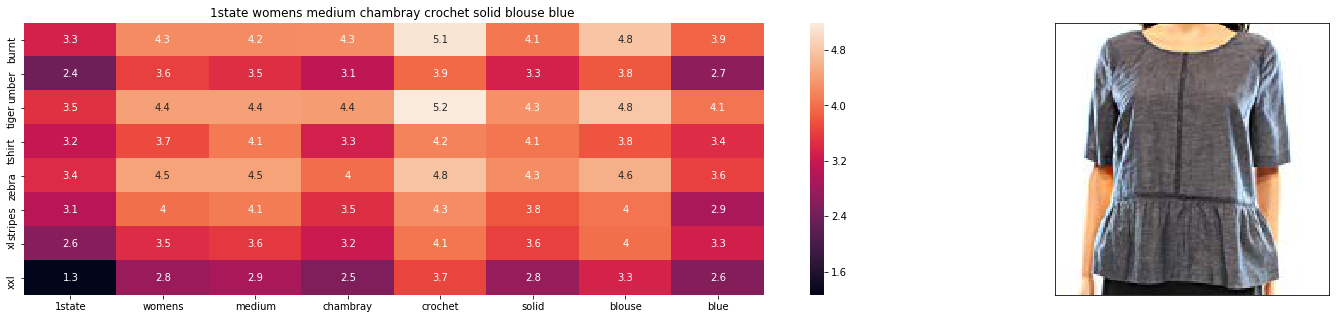

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074MK6LV2
Brand : 1.State
euclidean distance from input : 22.05204022568485


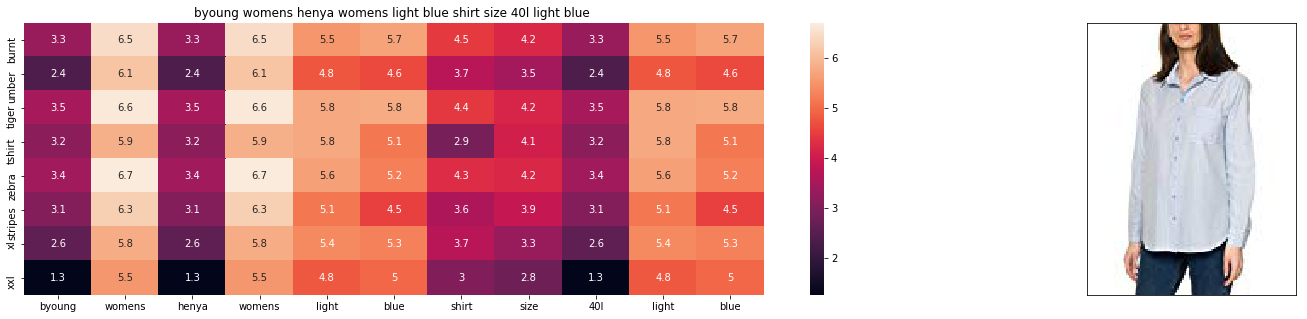

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B06Y41MRCH
Brand : Byoung
euclidean distance from input : 22.13864927309939


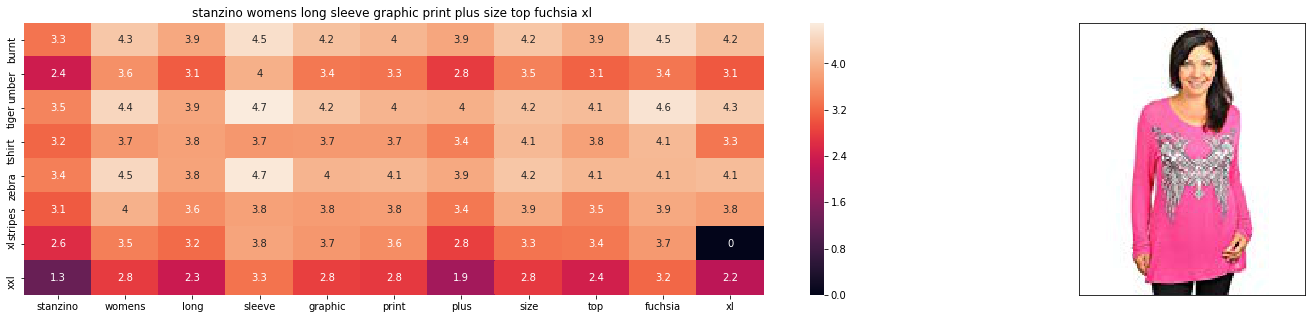

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00DP4VHWI
Brand : Stanzino
euclidean distance from input : 22.169047624290194


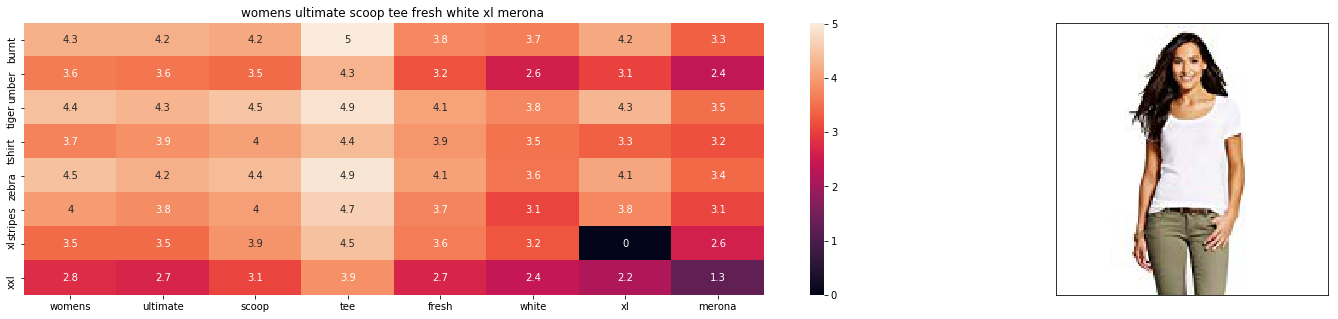

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01G7XE50E
Brand : Merona
euclidean distance from input : 22.19582102936527


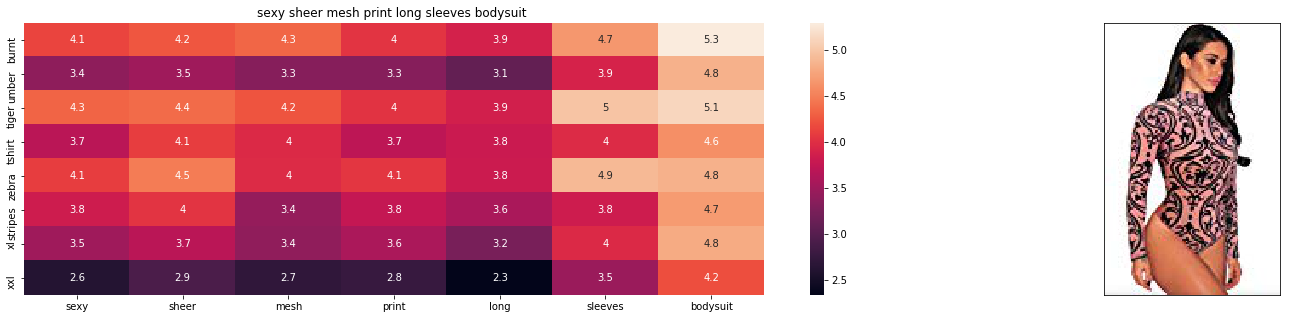

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B074Z5C98D
Brand : Ariella's closet
euclidean distance from input : 22.251077188532758


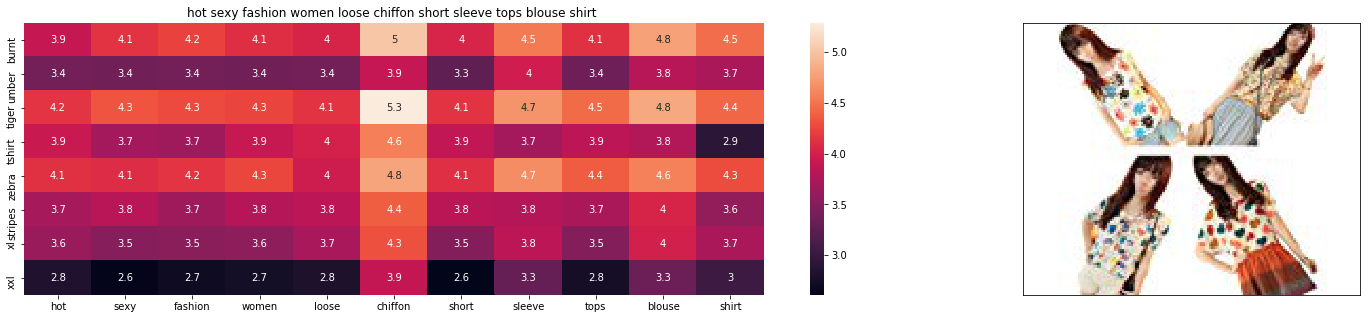

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B00JMAASRO
Brand : Wotefusi
euclidean distance from input : 22.253315383613316


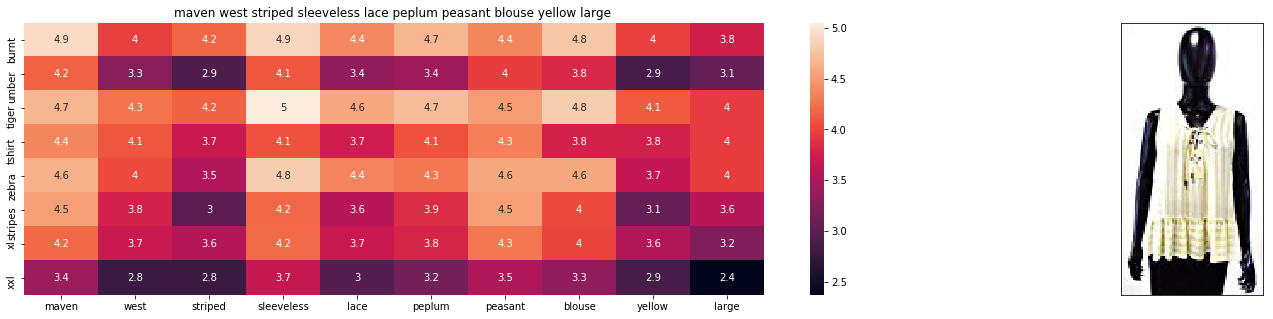

ASIN_Q : B00JXQB5FQ
Brand_Q : Si Row
ASIN : B01M8GB3AL
Brand : Maven West
euclidean distance from input : 22.267398452939478


In [91]:
idf_w2v_brand(doc_id=12566, idf_wt=5, ex_feat_wt=5, image_feat_wt=10, num_results=20)